In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import os

from numpy import set_printoptions
from scipy.stats import skew
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import classification_report,confusion_matrix

import keras
#from keras.optimizers import SGD
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import LeaveOneOut

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold

from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score


from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

import xgboost
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
import os

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dropout, Activation, Dense, BatchNormalization
#from keras.optimizers import RMSprop
import os
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:
from pathlib import Path
from typing import List, Optional
import pandas as pd
from google.colab import drive
import shutil
import os

# Mount Google Drive
drive.mount("/content/drive")
print("\n--- Google Drive Mounting Complete ---\n")

# Configuration
SOURCE_FILES = [
    '/content/Predictions.xlsx',
    '/content/oasis_longitudinal_demographics.xlsx'
]
TARGET_DIR = '/content/drive/MyDrive/Datasets/RuleBased_Dementia'
DATASET_PATHS = {
    "data": Path("/content/drive/MyDrive/Datasets/RuleBased_Dementia/oasis_longitudinal_demographics.xlsx"),
    "predictions": Path("/content/drive/MyDrive/Datasets/RuleBased_Dementia/Predictions.xlsx")
}

def transfer_files(
    source_files: List[str],
    target_dir: str,
    overwrite: bool = False
) -> None:
    """Manage file transfers to Google Drive with clean logging."""
    target = Path(target_dir)
    target.mkdir(parents=True, exist_ok=True)
    print(f"Target directory: {target}")

    transferred_files = 0
    skipped_files = 0

    for src in source_files:
        src_path = Path(src)
        dest = target / src_path.name

        if not src_path.exists():
            print(f"[Warning] Source not found: {src}")
            skipped_files += 1
            continue

        if dest.exists():
            if overwrite:
                dest.unlink()
                print(f"[Update] Overwriting existing file: {dest.name}")
            else:
                print(f"[Notice] File exists, skipping: {dest.name}")
                skipped_files += 1
                continue

        shutil.move(str(src_path), str(dest))
        print(f"[Success] Transferred: {src_path.name}")
        transferred_files += 1

    print(f"\nTransfer Summary: {transferred_files} files moved, {skipped_files} files skipped\n")

def load_dataset(path: Path) -> Optional[pd.DataFrame]:
    """Load dataset with comprehensive error reporting."""
    try:
        if not path.exists():
            print(f"[Error] File not found: {path.name}")
            return None

        if path.suffix.lower() not in ['.xlsx', '.xls']:
            print(f"[Error] Invalid file format: {path.suffix}")
            return None

        print(f"[Status] Loading dataset: {path.name}")
        df = pd.read_excel(path)
        print(f"[Success] Loaded {len(df)} rows, {len(df.columns)} columns")
        return df

    except Exception as e:
        print(f"[Critical] Loading failed for {path.name}: {str(e)}")
        return None

# File Transfer Execution
# print("--- Starting File Transfer ---")
# transfer_files(SOURCE_FILES, TARGET_DIR, overwrite=True)

# Dataset Loading
print("\n--- Dataset Initialization ---")
df_data = load_dataset(DATASET_PATHS["data"])
df_pred = load_dataset(DATASET_PATHS["predictions"])

# Final Validation
print("\n--- System Status ---")
if df_data is not None:
    print(f"Data Dataset: Ready ({df_data.shape[0]}x{df_data.shape[1]})")
else:
    print("Data Dataset: Not loaded")

if df_pred is not None:
    print(f"Predictions Dataset: Ready ({df_pred.shape[0]}x{df_pred.shape[1]})")
else:
    print("Predictions Dataset: Not loaded")

Mounted at /content/drive

--- Google Drive Mounting Complete ---


--- Dataset Initialization ---
[Status] Loading dataset: oasis_longitudinal_demographics.xlsx
[Success] Loaded 373 rows, 15 columns
[Status] Loading dataset: Predictions.xlsx
[Success] Loaded 149 rows, 13 columns

--- System Status ---
Data Dataset: Ready (373x15)
Predictions Dataset: Ready (149x13)


In [4]:
import pandas as pd
import seaborn as sns
from IPython.display import display, HTML

class DataAnalyzer:
    def __init__(self, df: pd.DataFrame):
        self.raw_df = df
        self.clean_df = df.copy()
        self._configure_styles()

    def _configure_styles(self):
        """Configure visualization and display settings"""
        sns.set(style="darkgrid", context="notebook")
        pd.options.display.max_columns = None
        pd.options.display.width = 1000
        pd.options.display.max_colwidth = 50

    def _styled_display(self, df: pd.DataFrame, title: str = None):
        """Display DataFrame with custom styling"""
        if title:
            display(HTML(f"<h4 style='color:#2B5F75'>{title}</h4>"))
        display(
            df.style
            .background_gradient(cmap='Blues', subset=df.select_dtypes(include='number').columns)
            .set_properties(**{'border': '1px solid #d3d3d3', 'padding': '5px'})
            .format(precision=2)
        )

    def handle_missing_data(self) -> pd.DataFrame:
        """Handle missing values and return cleaned DataFrame"""
        initial_rows = len(self.clean_df)
        self.clean_df = self.raw_df.dropna()
        removed_rows = initial_rows - len(self.clean_df)

        display(HTML(
            f"<div style='background-color:#f0f8ff; padding:10px; border-left:4px solid #2B5F75'>"
            f"Data Cleaning Report: Removed {removed_rows} rows with missing values"
            f"</div>"
        ))

        return self.clean_df

    def show_column_info(self):
        """Display column metadata analysis"""
        col_info = pd.DataFrame({
            'Column': self.clean_df.columns,
            'Data Type': self.clean_df.dtypes,
            'Unique Values': self.clean_df.nunique(),
            'Missing Values': self.clean_df.isna().sum()
        })

        self._styled_display(col_info, "Column Metadata Analysis")

    def show_summary_stats(self):
        """Display enhanced summary statistics"""
        stats_df = self.clean_df.describe().T
        stats_df['skewness'] = self.clean_df.skew(numeric_only=True)
        stats_df['kurtosis'] = self.clean_df.kurtosis(numeric_only=True)

        self._styled_display(stats_df, "Numerical Summary Statistics")

    def analyze_categorical(self):
        """Analyze categorical variables with visual formatting"""
        cat_cols = self.clean_df.select_dtypes(include='object').columns

        if len(cat_cols) == 0:
            display(HTML("<div style='color:#856404; background-color:#fff3cd; padding:10px;'>"
                         "No categorical variables found in the dataset</div>"))
            return

        for col in cat_cols:
            counts = self.clean_df[col].value_counts(dropna=False)
            percentages = self.clean_df[col].value_counts(normalize=True, dropna=False) * 100

            result = pd.DataFrame({
                'Count': counts,
                'Percentage': percentages.round(2)
            })

            self._styled_display(result, f"Categorical Analysis: {col}")

    def show_data_slice(self, start: int = 20, end: int = 60):
        """Display formatted data slice with bounds checking"""
        if start < 0 or end > len(self.clean_df):
            display(HTML("<div style='color:#721c24; background-color:#f8d7da; padding:10px;'>"
                         "Invalid index range provided</div>"))
            return

        slice_df = self.clean_df.iloc[start:end]
        self._styled_display(slice_df, f"Data Slice (Rows {start}-{end})")

    def preview(self, rows: int = 5):
        """Show styled head/tail preview"""
        self._styled_display(
            pd.concat([self.clean_df.head(rows), self.clean_df.tail(rows)]),
            f"First & Last {rows} Rows"
        )


In [5]:
# Usage example
analyzer = DataAnalyzer(df_data)
df_data_clean = analyzer.handle_missing_data()
analyzer.show_column_info()
analyzer.show_summary_stats()
# analyzer.analyze_categorical()
analyzer.show_data_slice(20, 60)
analyzer.preview(3)

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np

class DementiaVisualizer:
    def __init__(self, df, target='Group', palette='coolwarm'):
        self.df = df
        self.target = target
        self.palette = palette
        self._set_styles()

    def _set_styles(self):
        """Configure visualization settings"""
        sns.set(style="darkgrid", context="notebook")
        rcParams.update({
            'figure.figsize': (10, 6),
            'axes.titlesize': 14,
            'axes.titleweight': 'bold',
            'axes.labelsize': 12
        })

    def _add_plot_details(self, ax, title, annotate=False):
        """Add common plot elements"""
        ax.set_title(title)
        if annotate:
            for p in ax.patches:
                ax.annotate(f'{p.get_height():.0f}',
                           (p.get_x() + p.get_width() / 2., p.get_height()),
                           ha='center', va='center',
                           xytext=(0, 5),
                           textcoords='offset points')
        plt.tight_layout()

    def _get_categorical_plot_data(self, col):
        """Handle categorical data preprocessing"""
        plot_data = self.df[col].value_counts(normalize=True).reset_index()
        plot_data.columns = ['category', 'proportion']  # Force consistent column names
        return plot_data

    def univariate_analysis(self, col, bins=20, figsize=(10,6)):
        """Enhanced univariate analysis with proper categorical handling"""
        fig, ax = plt.subplots(figsize=figsize)

        try:
            if np.issubdtype(self.df[col].dtype, np.number):
                sns.histplot(data=self.df, x=col, hue=self.target,
                            element='step', bins=bins, kde=True,
                            palette=self.palette, ax=ax)
                ax.set_title(f'{col} Distribution')
            else:
                plot_data = self._get_categorical_plot_data(col)
                sns.barplot(data=plot_data, x='category', y='proportion',
                           palette=self.palette, hue='category', ax=ax)
                ax.set_title(f'{col} Distribution')
                ax.set_xlabel(col)
                ax.set_ylabel('Proportion')

                # Add annotations
                for p in ax.patches:
                    ax.annotate(f'{p.get_height():.2f}',
                               (p.get_x() + p.get_width() / 2., p.get_height()),
                               ha='center', va='center',
                               xytext=(0, 5),
                               textcoords='offset points')

            plt.tight_layout()
            plt.show()

        except KeyError as e:
            print(f"Error: Column {e} not found in dataframe")
        except Exception as e:
            print(f"An error occurred: {str(e)}")

    def bivariate_analysis(self, x, y, plot_type='lmplot', figsize=(10,6)):
        """Bivariate relationship analysis"""
        plt.figure(figsize=figsize)

        if plot_type == 'lmplot':
            grid = sns.lmplot(data=self.df, x=x, y=y, hue=self.target,
                            palette=self.palette, height=figsize[1],
                            aspect=figsize[0]/figsize[1],
                            scatter_kws={'alpha':0.6})
            grid.fig.suptitle(f'{x} vs {y} Linear Regression', y=1.02)

        elif plot_type == 'scatter':
            ax = sns.scatterplot(data=self.df, x=x, y=y, hue=self.target,
                                palette=self.palette, alpha=0.7)
            self._add_plot_details(ax, f'{x} vs {y} Relationship')

        elif plot_type == 'box':
            ax = sns.boxplot(data=self.df, x=x, y=y, hue=self.target,
                            palette=self.palette)
            self._add_plot_details(ax, f'{x} vs {y} Distribution')

        plt.show()

    def multivariate_analysis(self, cols=None, figsize=(12,8)):
        """Multivariate relationship analysis"""
        if not cols:
            cols = ['Age', 'MMSE', 'eTIV', 'nWBV', 'ASF', 'CDR']

        # Pairplot with target differentiation
        grid = sns.pairplot(self.df[cols + [self.target]],
                           hue=self.target,
                           palette=self.palette,
                           plot_kws={'alpha':0.6, 'edgecolor':'w'},
                           diag_kind='kde')
        grid.fig.suptitle('Multivariate Relationships', y=1.02)
        plt.show()

        # Correlation matrix
        plt.figure(figsize=figsize)
        corr = self.df[cols].corr()
        mask = np.triu(np.ones_like(corr, dtype=bool))
        sns.heatmap(corr, mask=mask, annot=True, cmap=self.palette,
                   center=0, fmt='.2f')
        plt.title('Feature Correlation Matrix')
        plt.show()

    def longitudinal_analysis(self, subject_id_col='Subject ID',
                             time_var='Visit', figsize=(12,6)):
        """Longitudinal trajectory visualization"""
        plt.figure(figsize=figsize)
        ax = sns.lineplot(data=self.df, x=time_var, y='MMSE',
                         hue=self.target, style=subject_id_col,
                         palette=self.palette, estimator=None,
                         alpha=0.4, markers=True, dashes=False)
        self._add_plot_details(ax, 'Longitudinal MMSE Trajectories')
        plt.show()

    def brain_volume_analysis(self, figsize=(15,5)):
        """Specialized brain volume visualization"""
        fig, axes = plt.subplots(1, 3, figsize=figsize)

        # eTIV distribution
        sns.violinplot(data=self.df, x=self.target, y='eTIV',
                      palette=self.palette, ax=axes[0])
        axes[0].set_title('Total Intracranial Volume (eTIV)')

        # nWBV distribution
        sns.boxplot(data=self.df, x=self.target, y='nWBV',
                   palette=self.palette, ax=axes[1])
        axes[1].set_title('Normalized Whole Brain Volume (nWBV)')

        # ASF relationship
        sns.scatterplot(data=self.df, x='eTIV', y='ASF', hue=self.target,
                       palette=self.palette, alpha=0.6, ax=axes[2])
        axes[2].set_title('Atlas Scaling Factor (ASF) vs eTIV')

        plt.tight_layout()
        plt.show()

    def _get_palette(self, n_colors=None):
        """Dynamically generate appropriate color palette"""
        if isinstance(self.palette, str):
            if n_colors:
                return sns.color_palette(self.palette, n_colors=n_colors)
            return sns.color_palette(self.palette)
        return self.palette

        # In univariate_analysis for numerical variables
        palette = self._get_palette(len(self.df[self.target].unique()))

        # In univariate_analysis for categorical variables
        n_categories = len(plot_data['category'])
        palette = self._get_palette(n_categories)

        # Added edge colors for better bar visibility
        edgecolor='black'
        linewidth=0.5


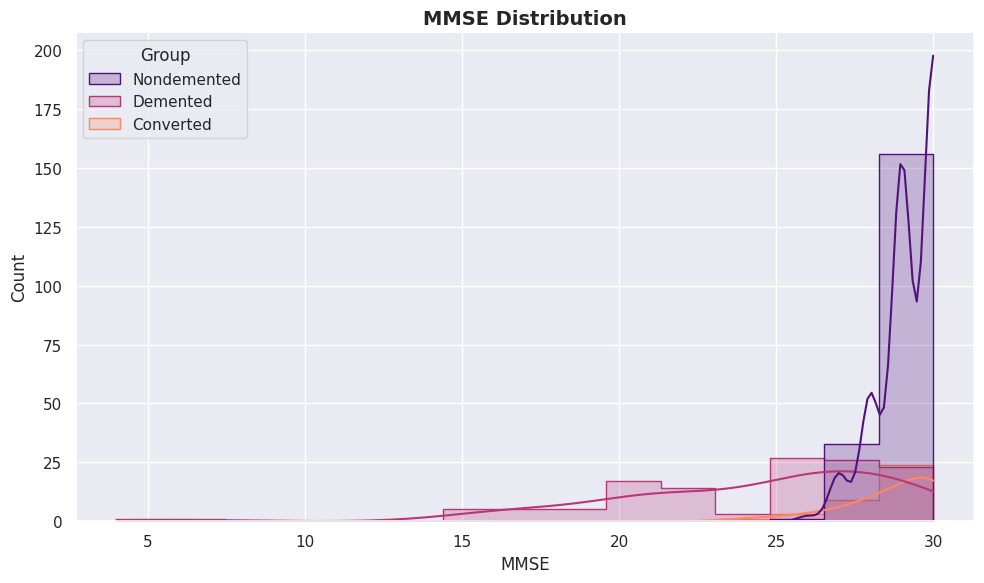

In [7]:
# Initialize with coolwarm palette
viz = DementiaVisualizer(df_data_clean, target='Group', palette='coolwarm')

viz = DementiaVisualizer(df_data_clean, palette='magma')

# Univariate analysis
viz.univariate_analysis('MMSE', bins=15)

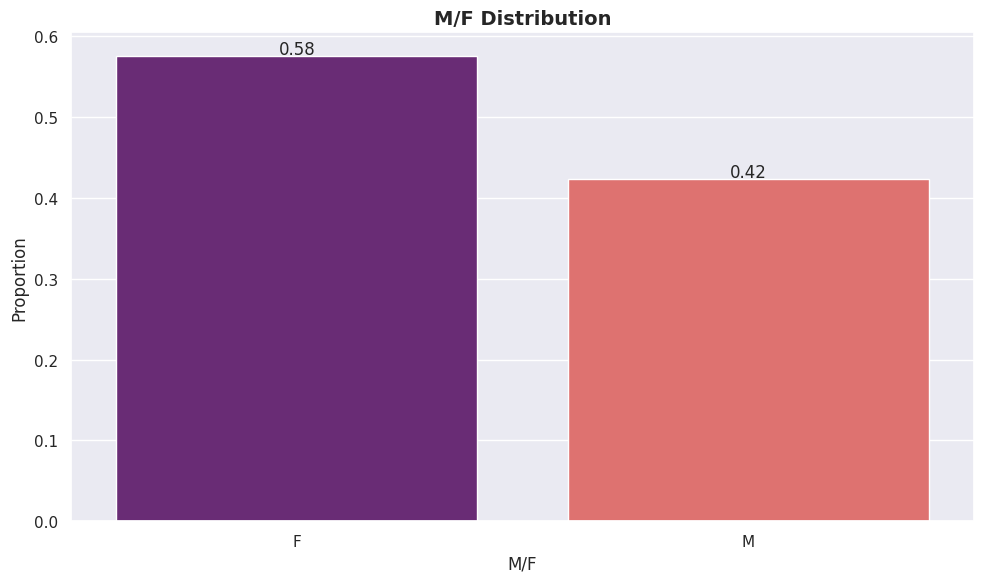

In [8]:
viz.univariate_analysis('M/F')

In [9]:
class DementiaVisualizer(DementiaVisualizer):
    def plot_demographic_features(self):
        """Univariate analysis of demographic features"""
        print("\n=== Demographic Feature Analysis ===")
        self.univariate_analysis('M/F')
        self.univariate_analysis('Age', bins=15)
        self.univariate_analysis('EDUC')

    def plot_cognitive_assessments(self):
        """Bivariate analysis of cognitive measures"""
        print("\n=== Cognitive Assessment Analysis ===")
        self.bivariate_analysis('Age', 'MMSE', plot_type='lmplot')
        self.bivariate_analysis('EDUC', 'MMSE', plot_type='scatter')
        self.bivariate_analysis('Group', 'MMSE', plot_type='box')

    def plot_brain_volume_analysis(self):
        """Multivariate analysis of brain measurements"""
        print("\n=== Brain Volume Analysis ===")
        self.bivariate_analysis('eTIV', 'nWBV', plot_type='scatter')
        self.bivariate_analysis('Age', 'nWBV', plot_type='lmplot')
        self.multivariate_analysis(cols=['eTIV', 'nWBV', 'ASF', 'Age'])

    def plot_disease_progression(self):
        """Temporal and CDR-related analysis"""
        print("\n=== Disease Progression Analysis ===")
        self.longitudinal_analysis()
        self.bivariate_analysis('Visit', 'CDR', plot_type='box')
        self.bivariate_analysis('Age', 'CDR', plot_type='lmplot')

    def plot_full_assessment(self):
        """Comprehensive analysis workflow"""
        print("\n=== Full Dataset Assessment ===")
        self.plot_demographic_features()
        self.plot_cognitive_assessments()
        self.plot_brain_volume_analysis()
        self.plot_disease_progression()


=== Demographic Feature Analysis ===


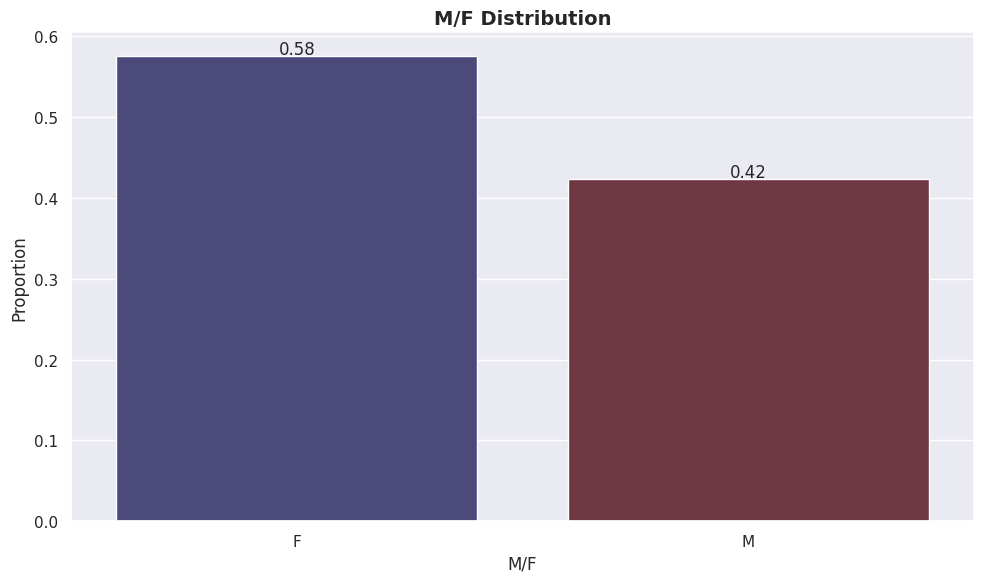

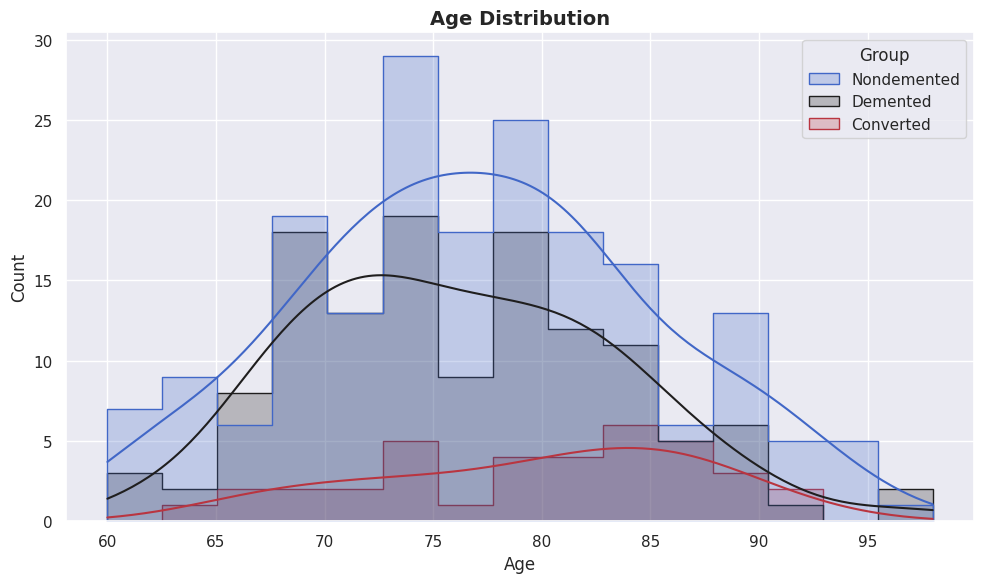

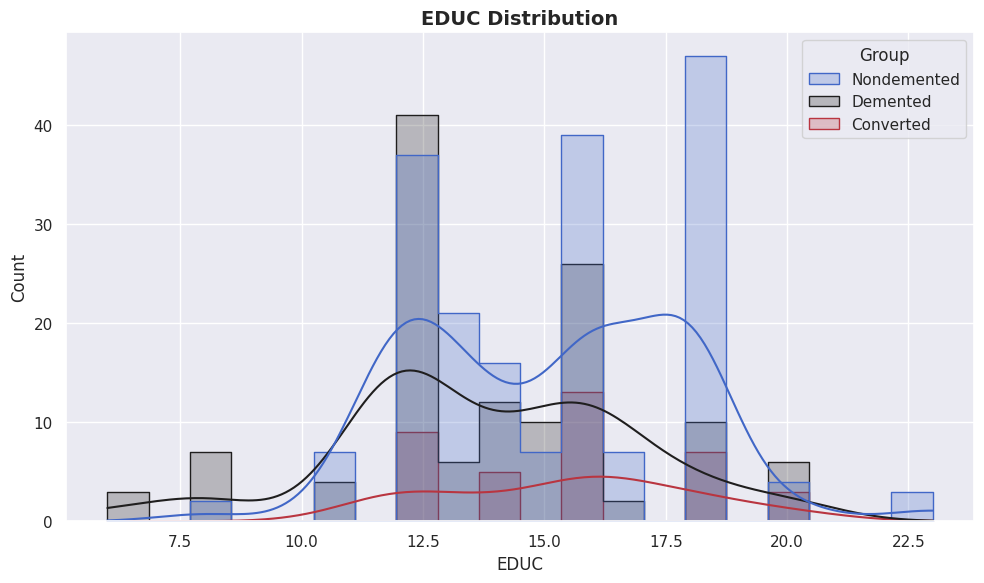


=== Cognitive Assessment Analysis ===


<Figure size 1000x600 with 0 Axes>

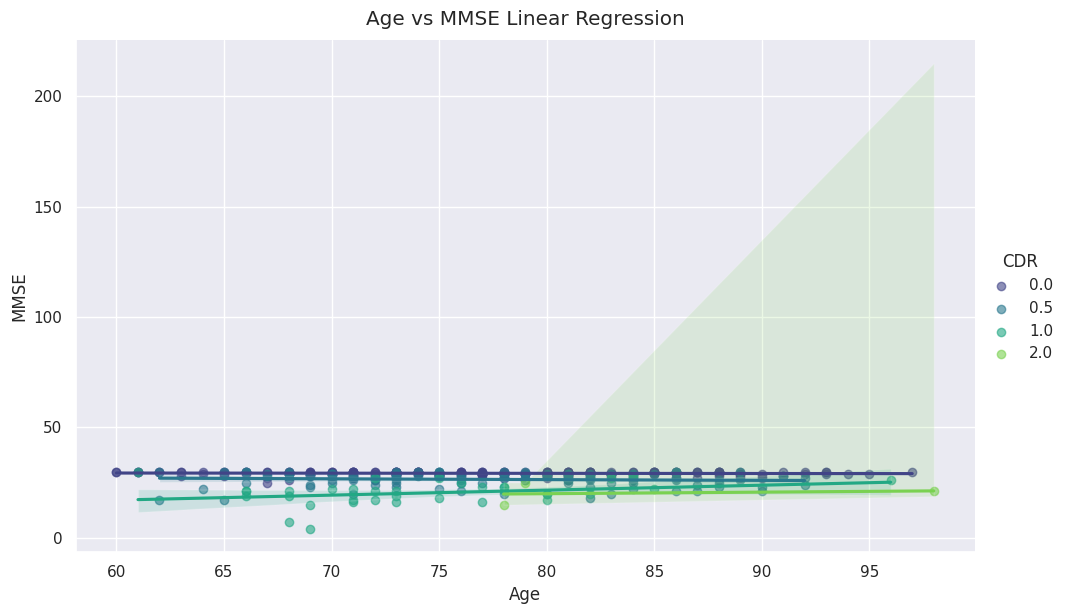

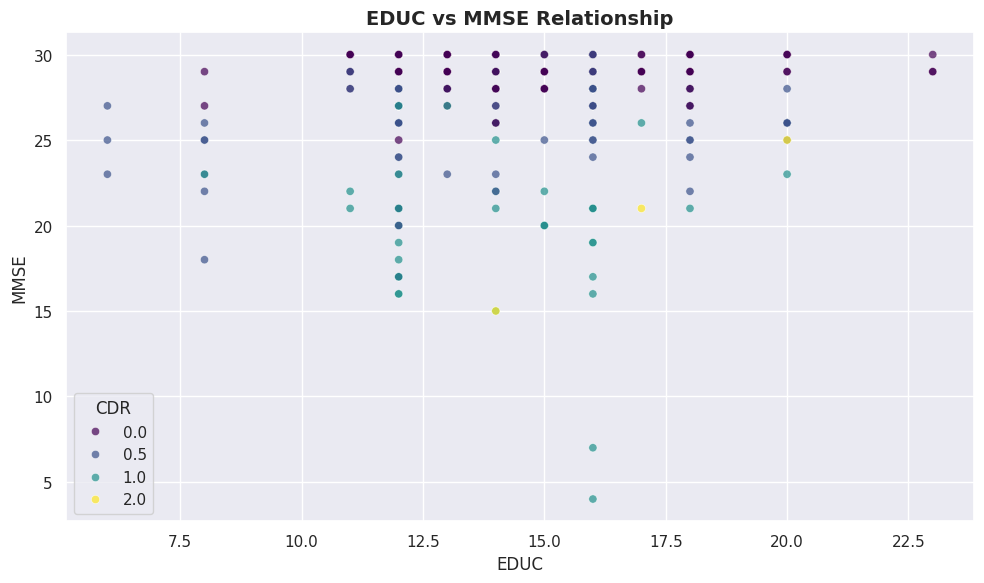

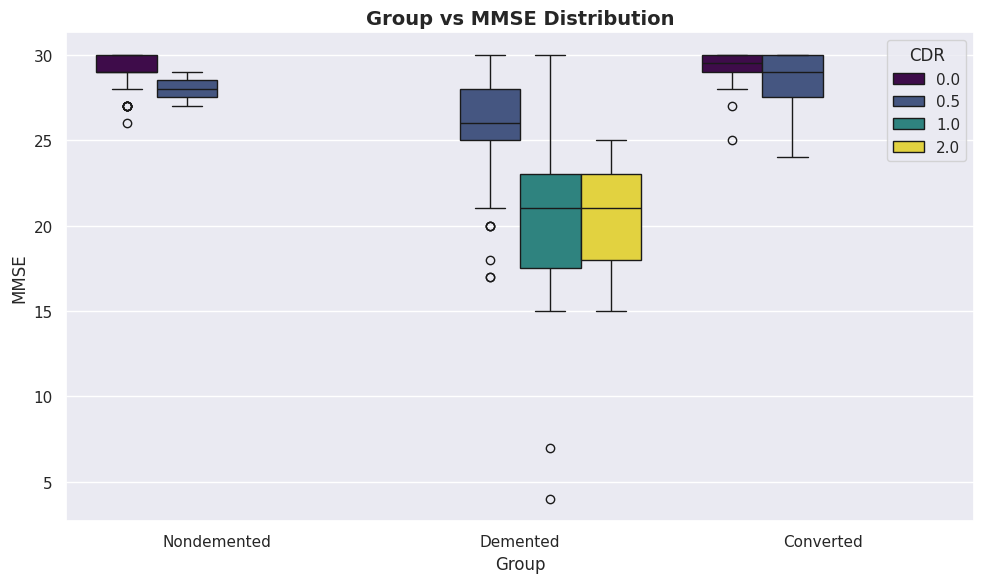


=== Brain Volume Analysis ===


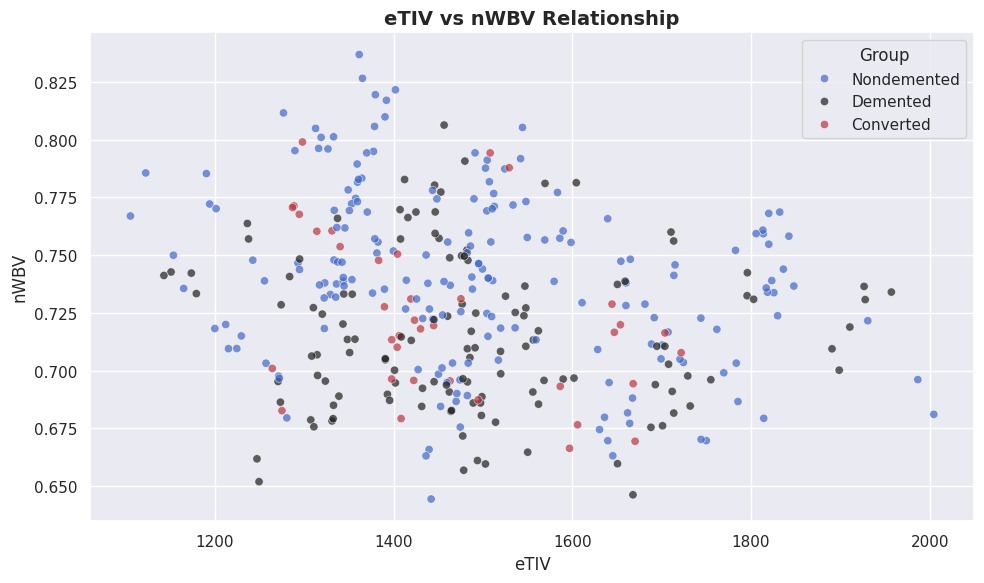

<Figure size 1000x600 with 0 Axes>

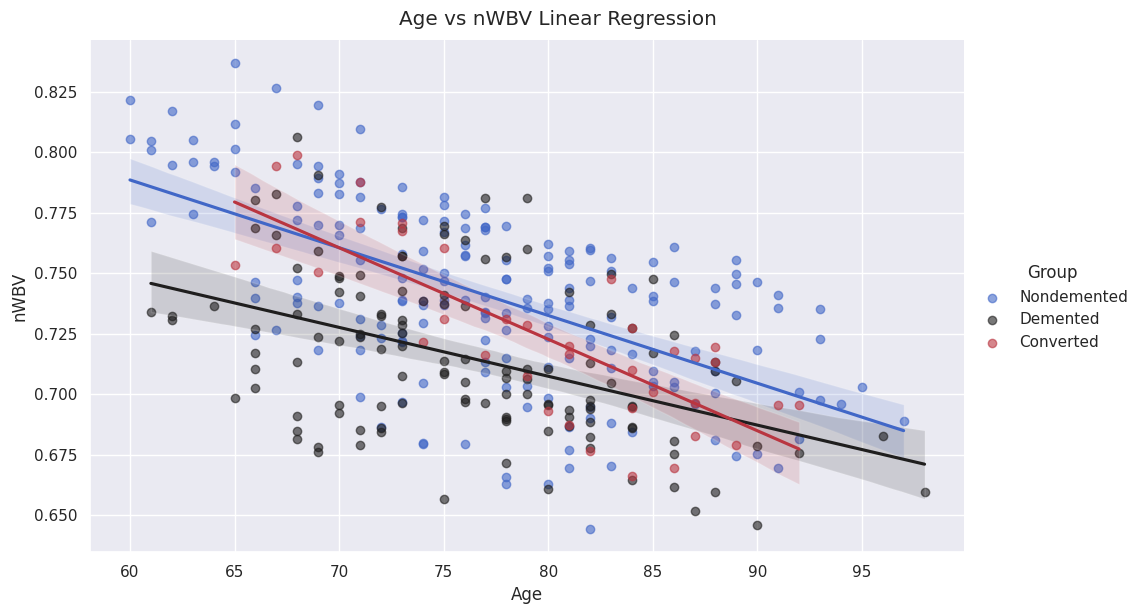

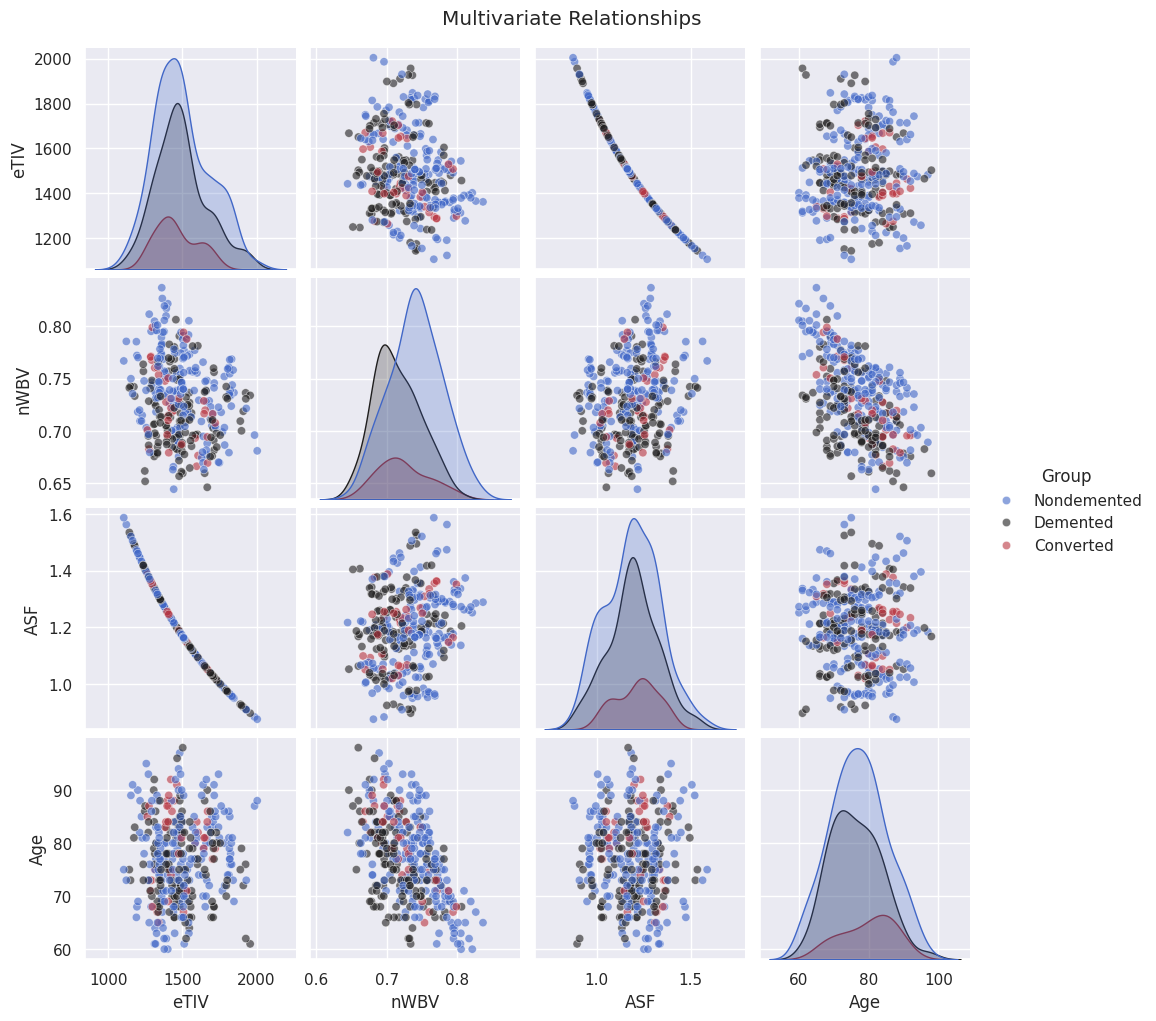

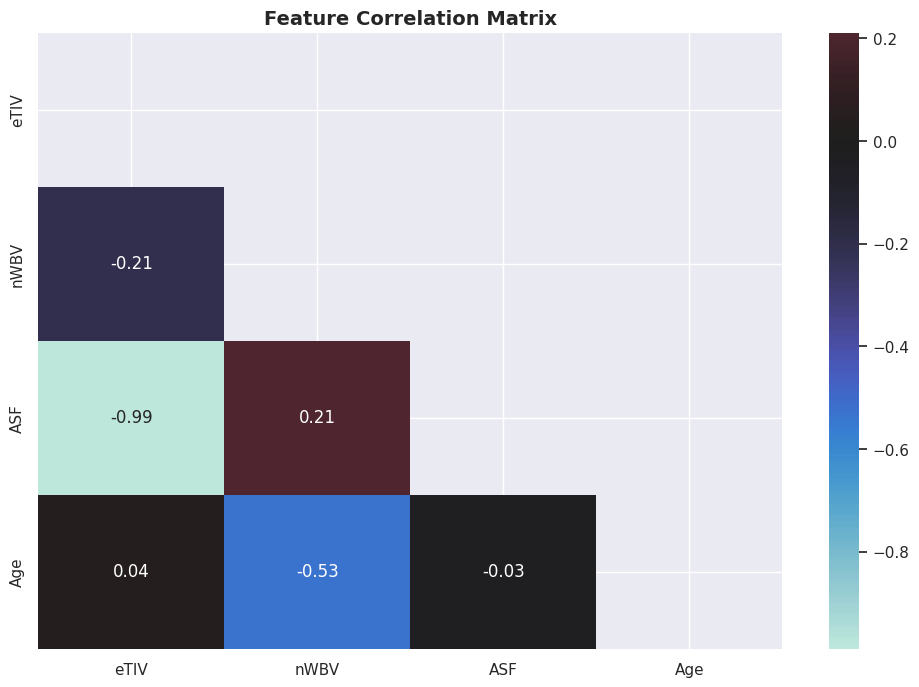


=== Full Dataset Assessment ===

=== Demographic Feature Analysis ===


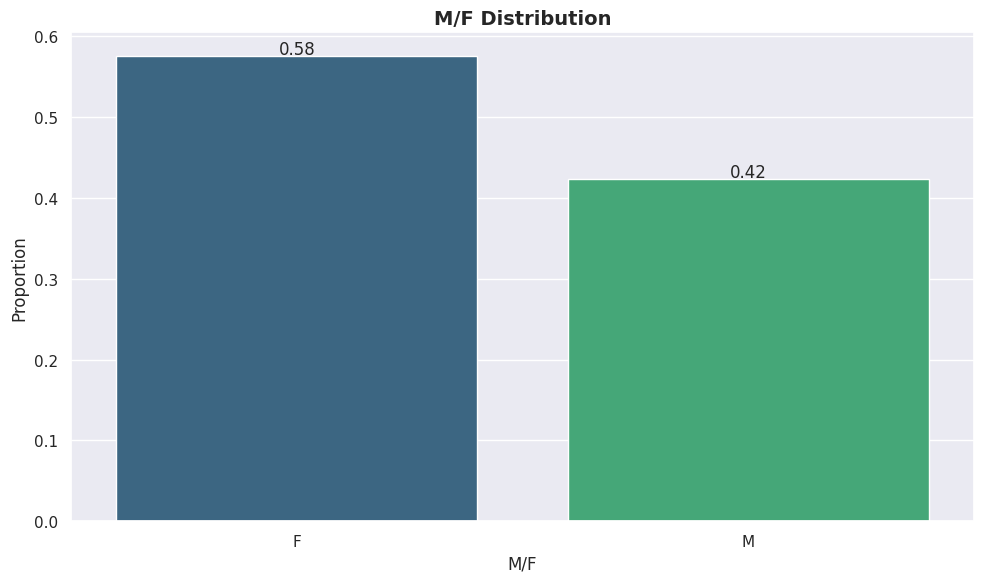

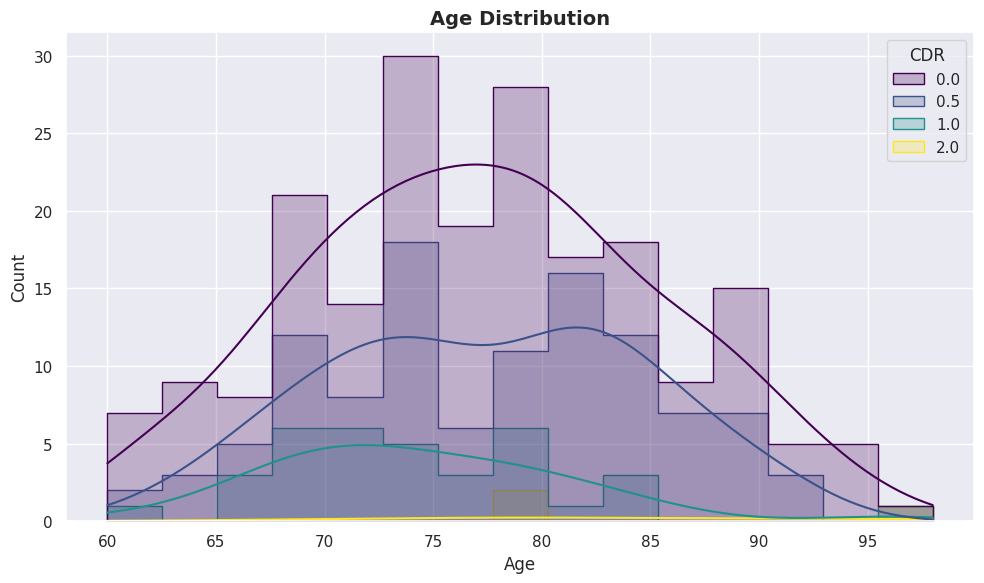

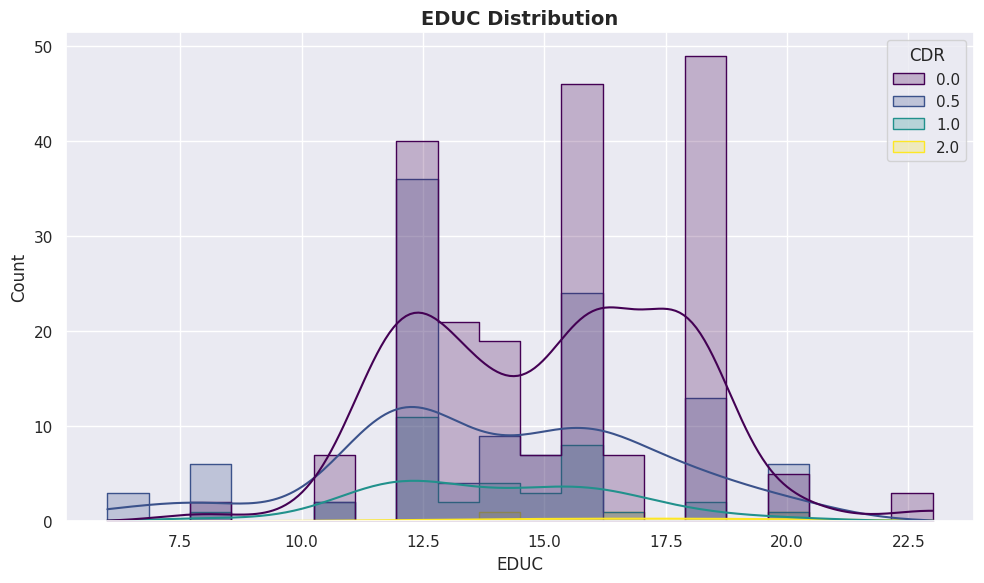


=== Cognitive Assessment Analysis ===


<Figure size 1000x600 with 0 Axes>

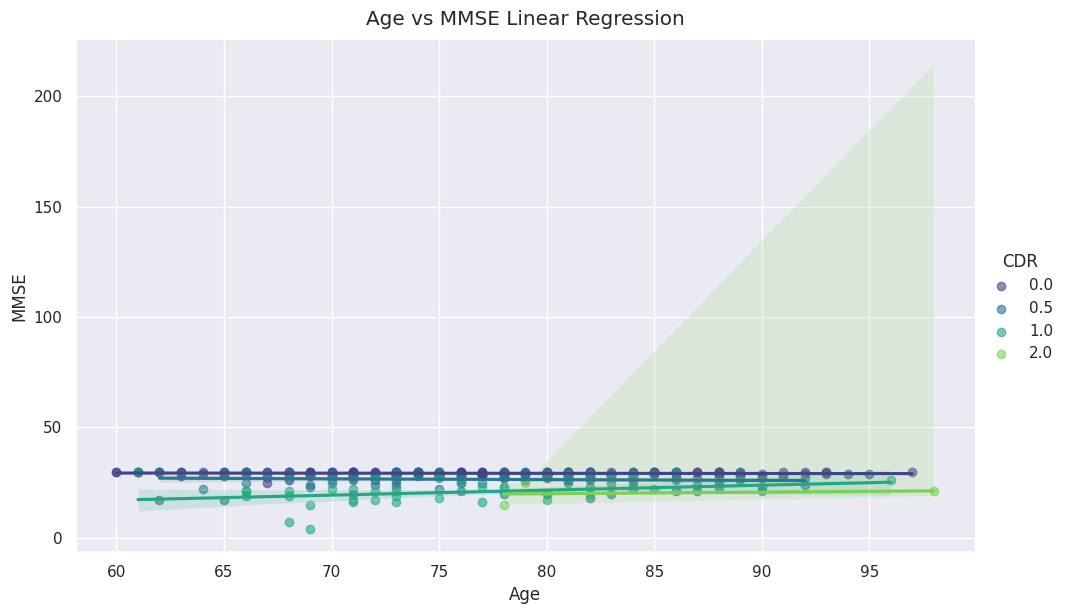

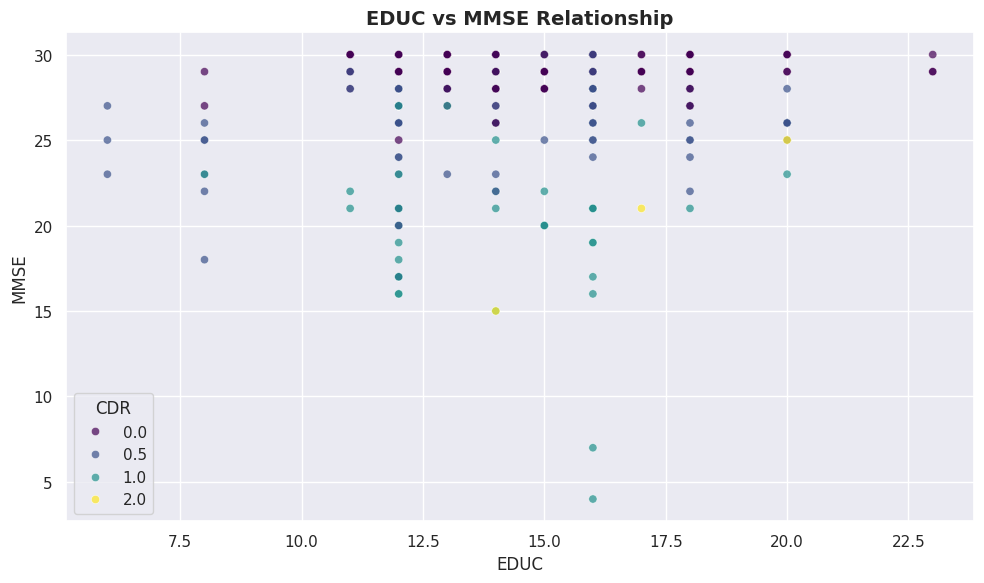

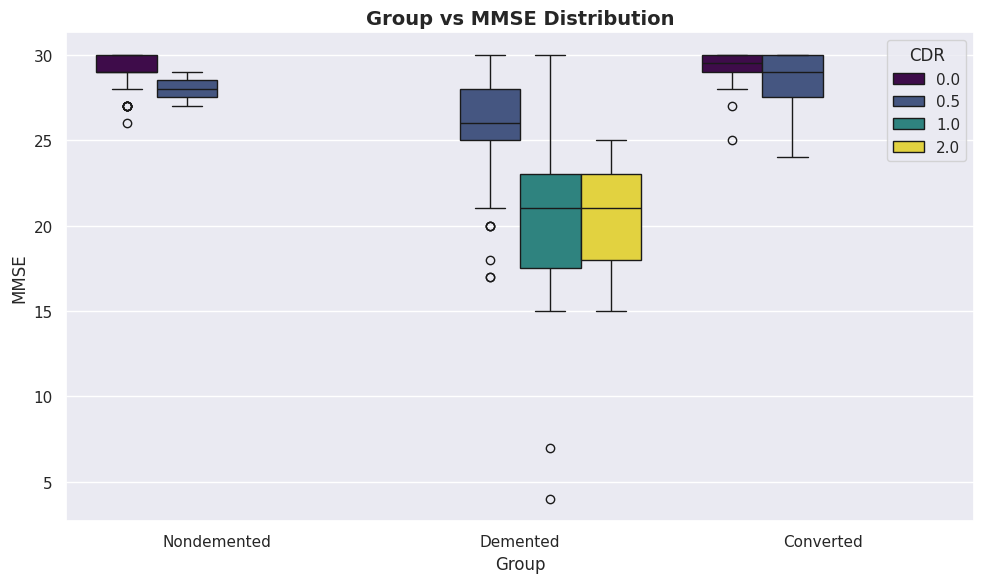


=== Brain Volume Analysis ===


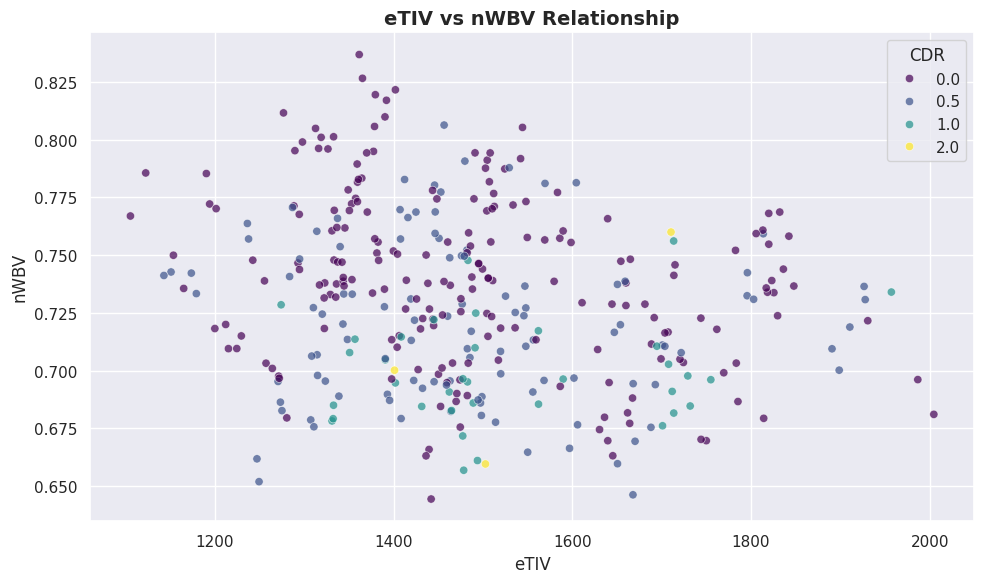

<Figure size 1000x600 with 0 Axes>

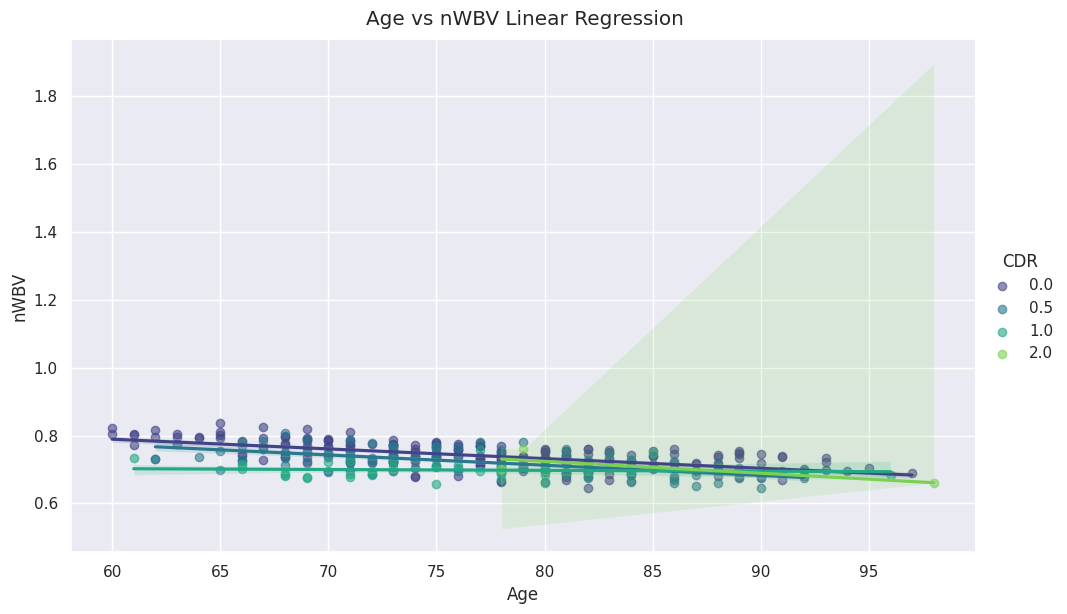

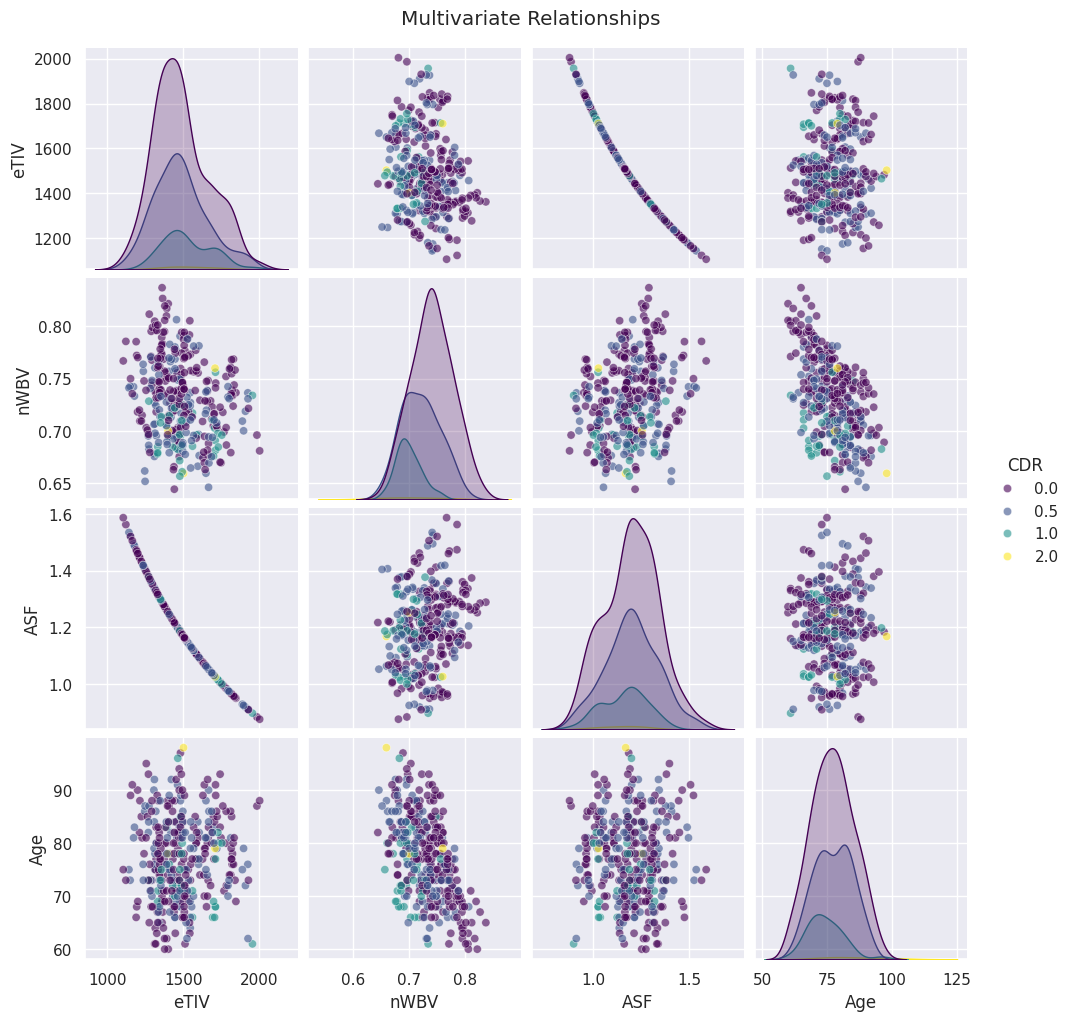

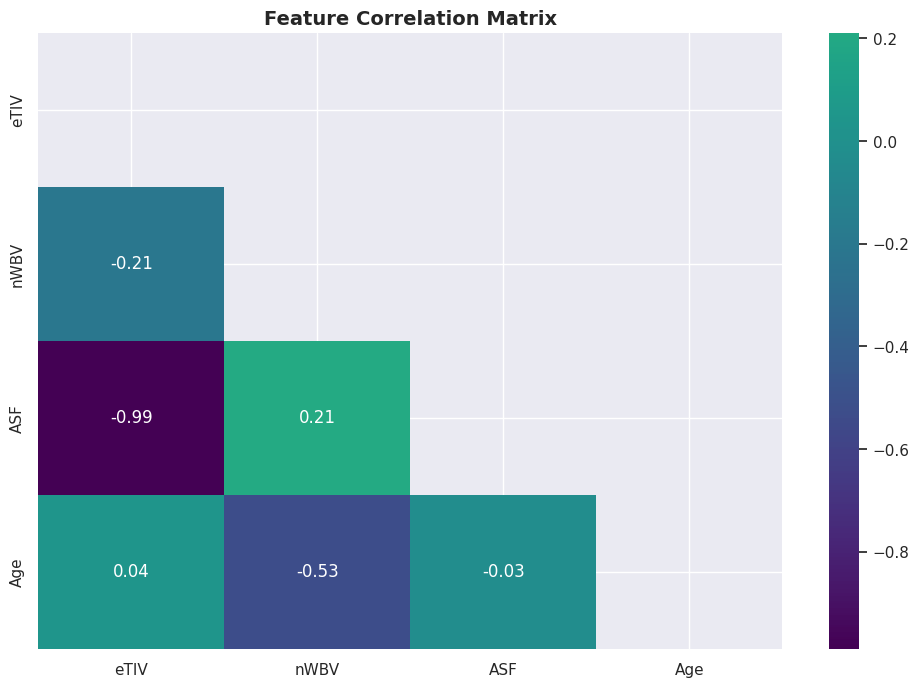


=== Disease Progression Analysis ===


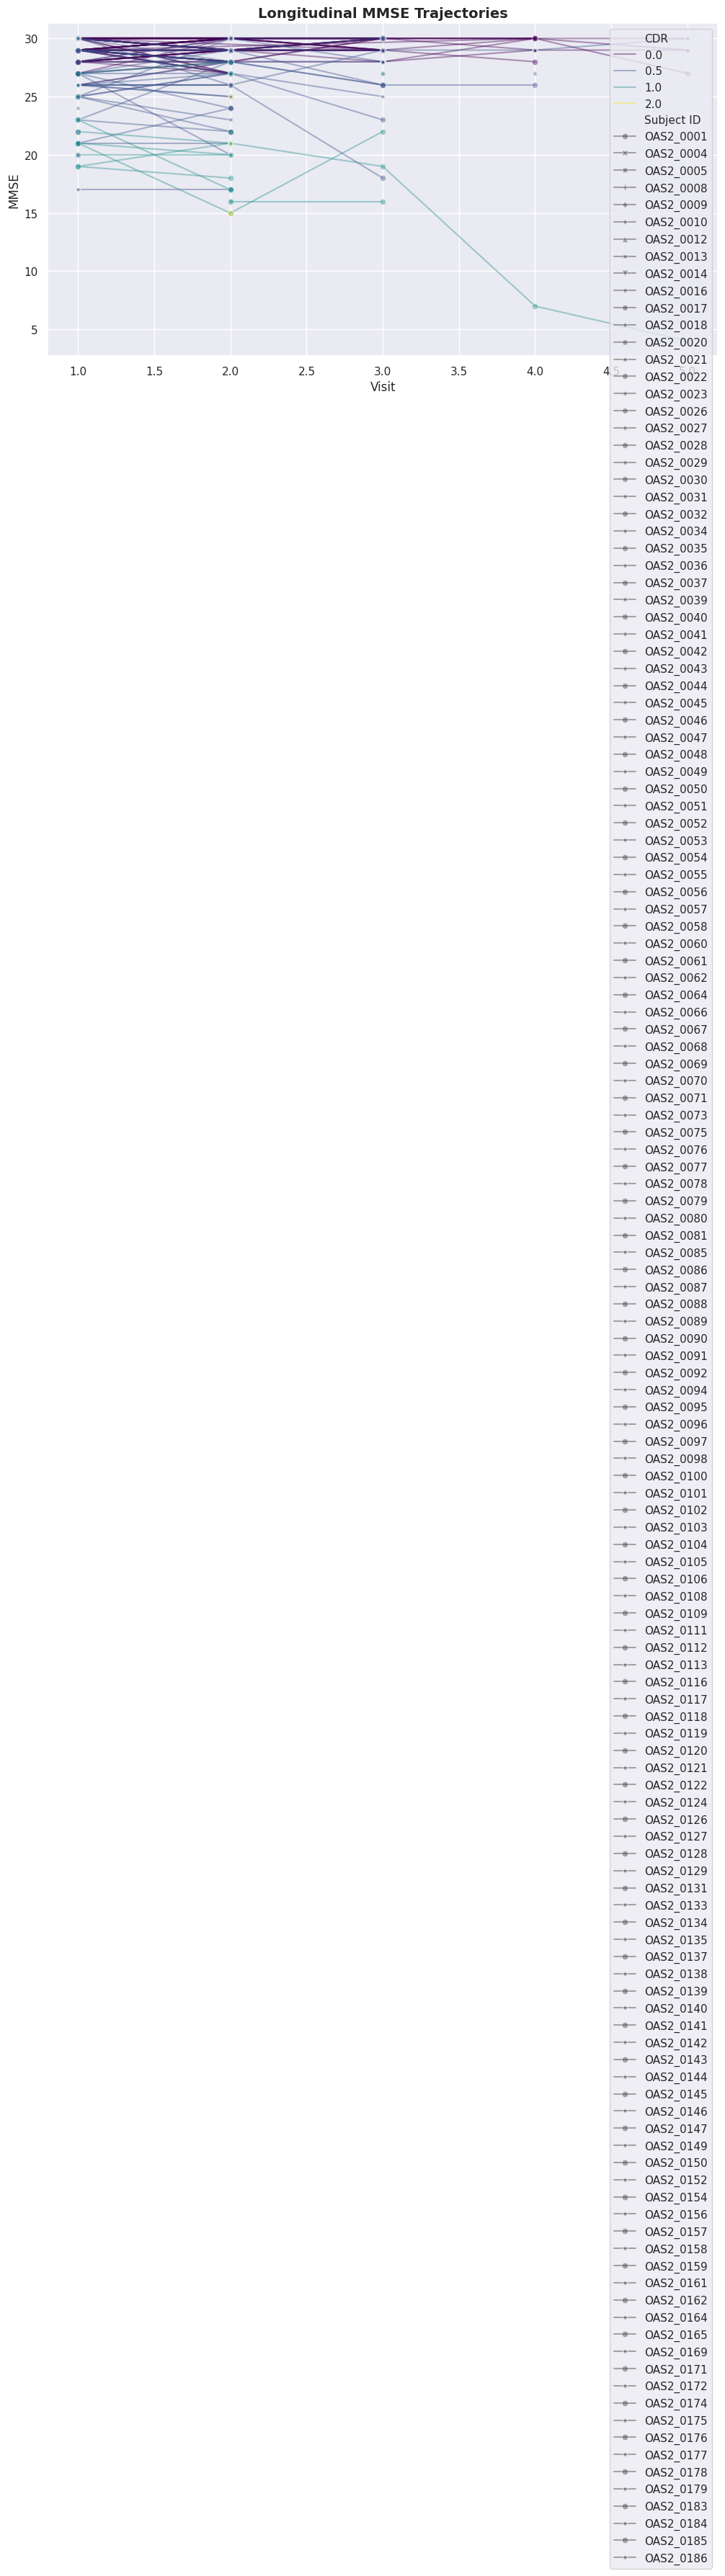

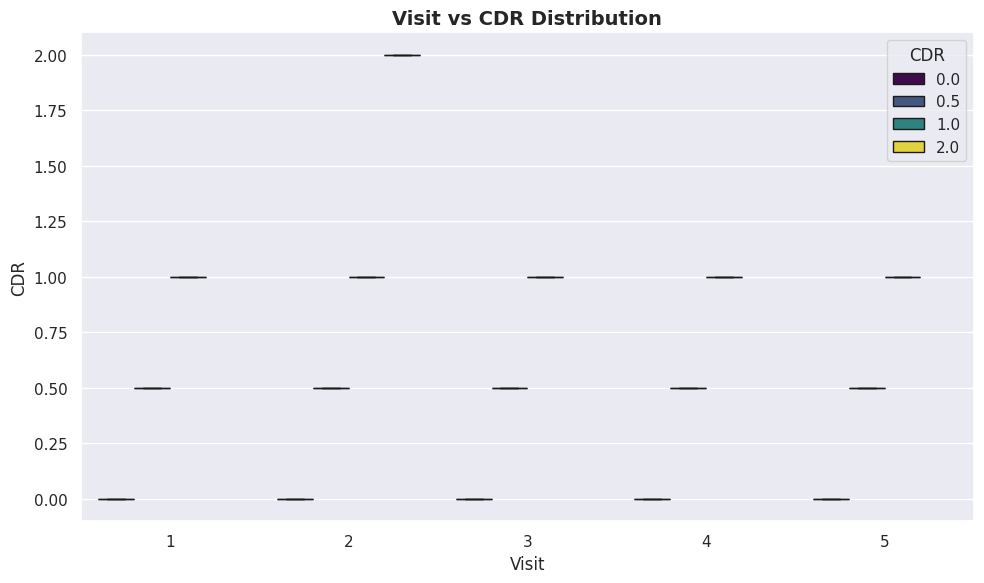

<Figure size 1000x600 with 0 Axes>

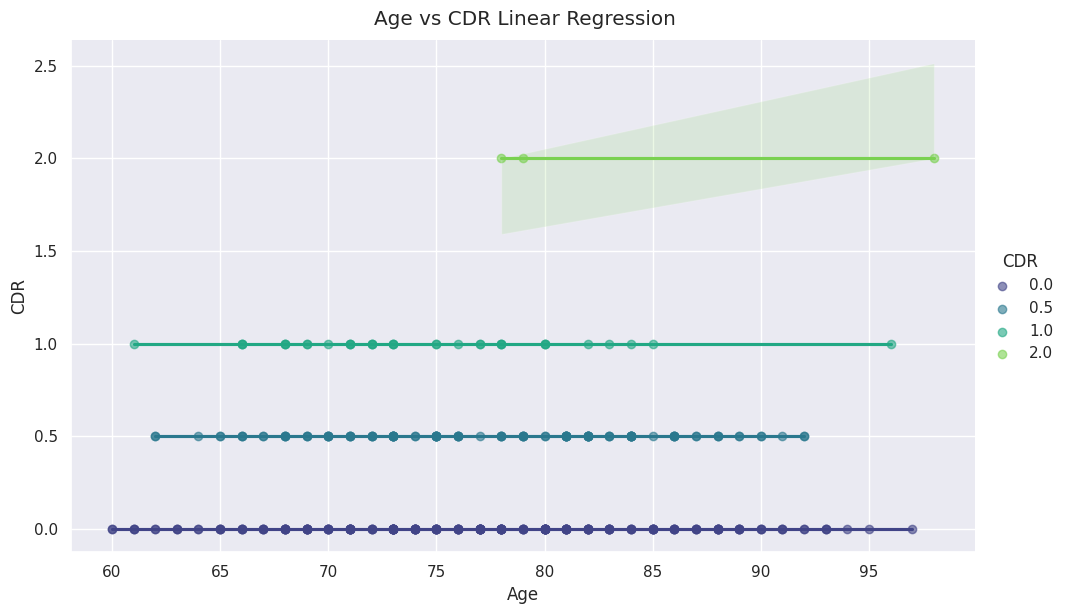

In [10]:
# Initialize with different targets
group_viz = DementiaVisualizer(df_data_clean, target='Group', palette= 'icefire')
cdr_viz = DementiaVisualizer(df_data_clean, target='CDR', palette='viridis')

# Run specific analysis types
group_viz.plot_demographic_features()      # Univariate
cdr_viz.plot_cognitive_assessments()       # Bivariate
group_viz.plot_brain_volume_analysis()     # Multivariate

# Complete workflow
cdr_viz.plot_full_assessment()

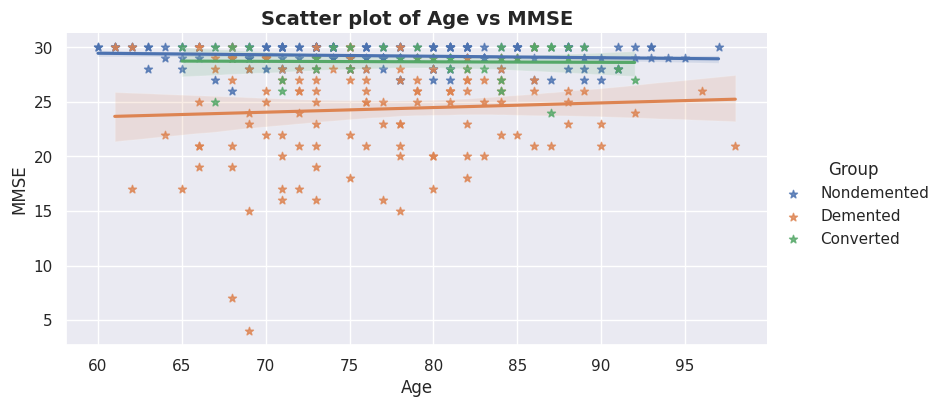

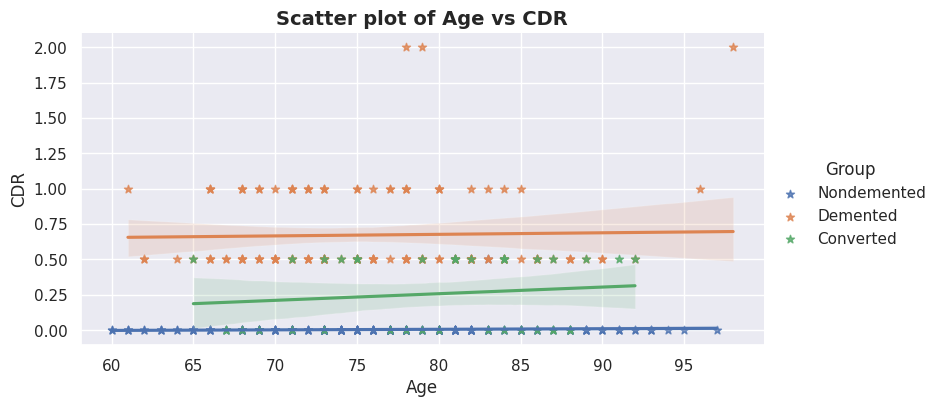

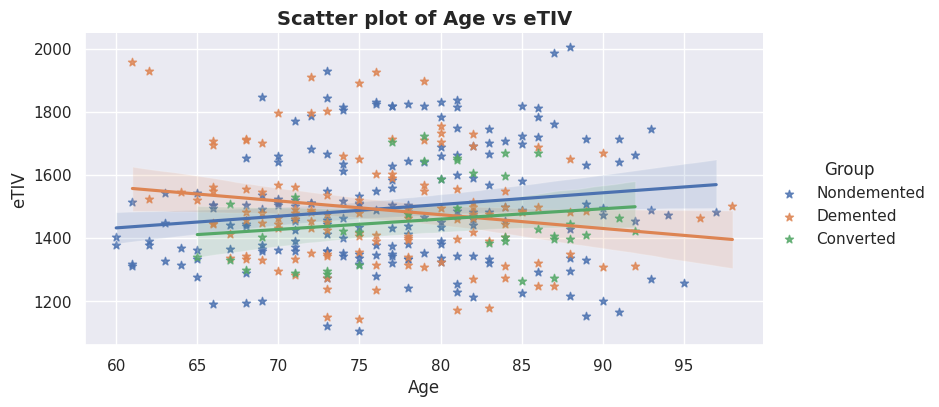

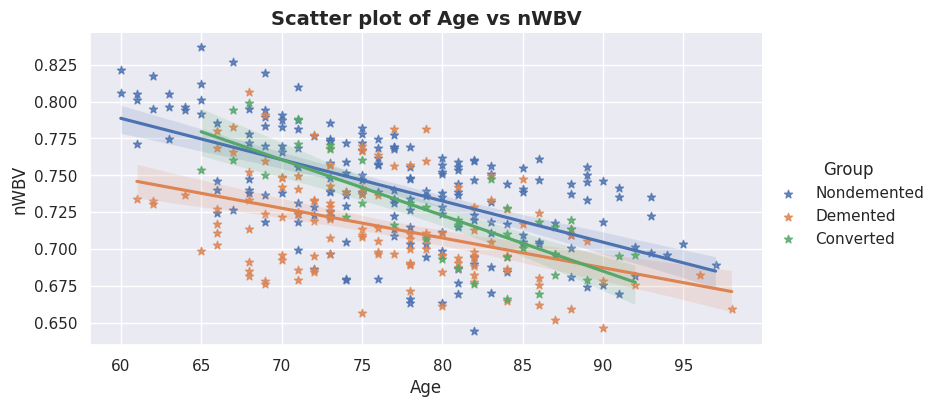

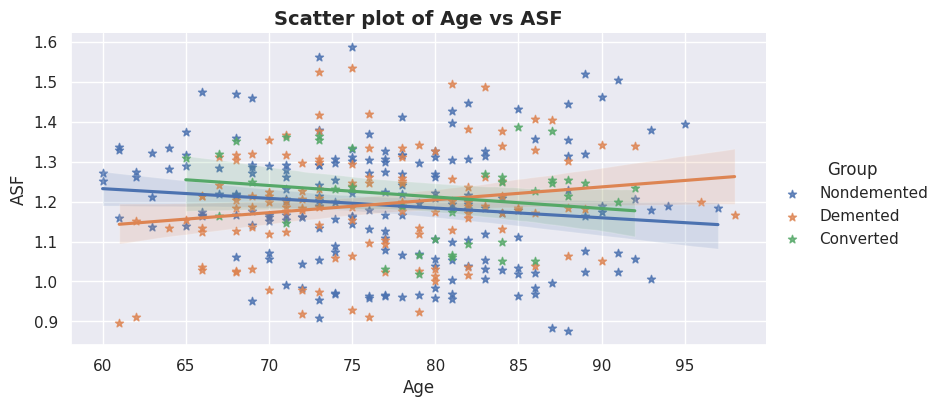

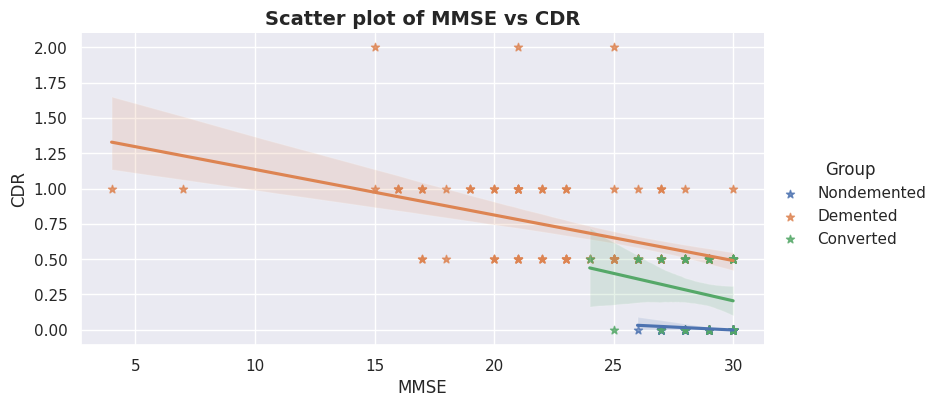

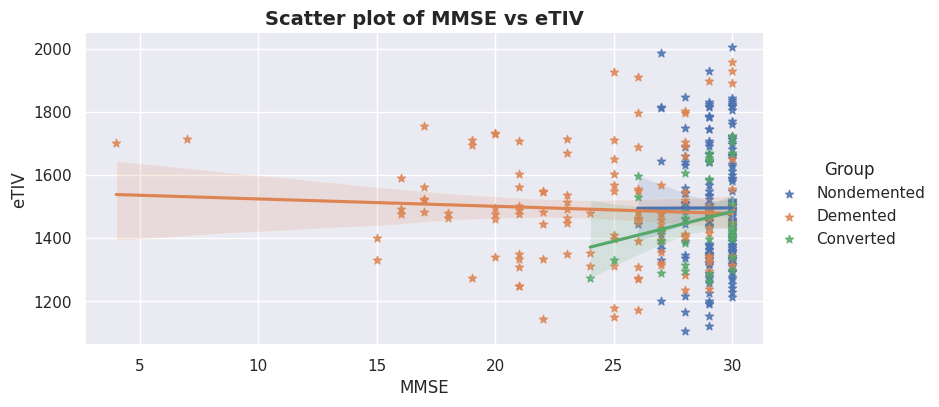

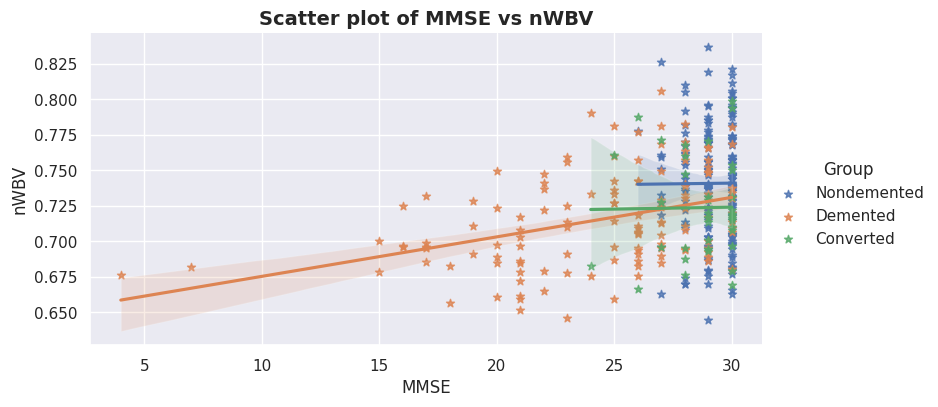

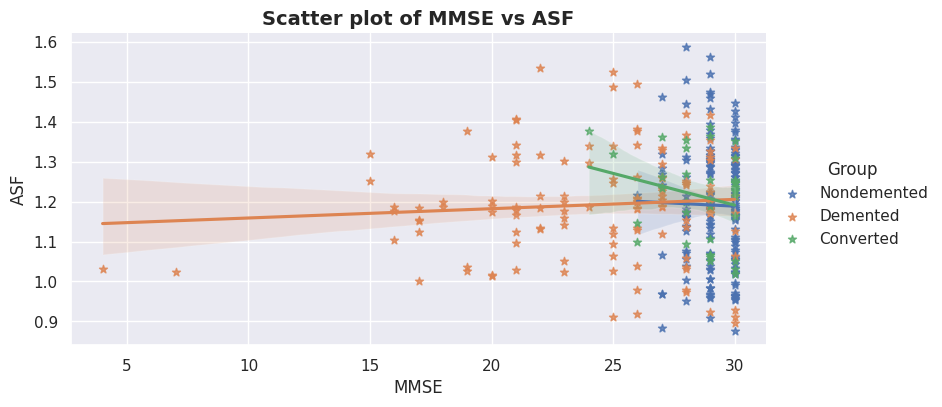

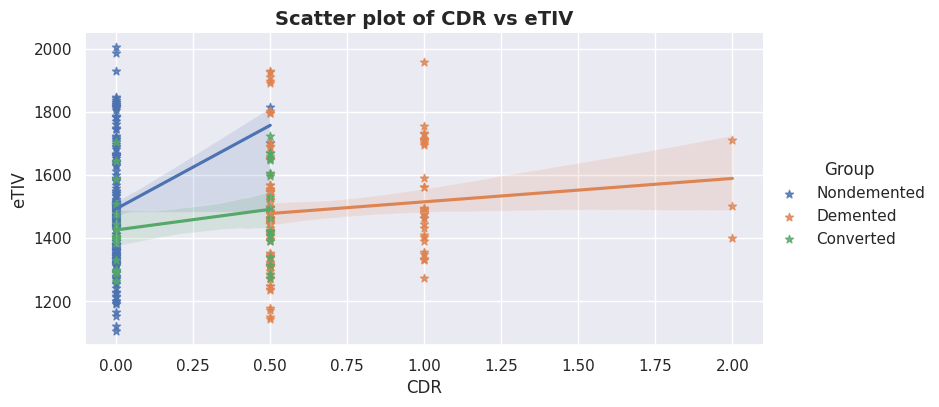

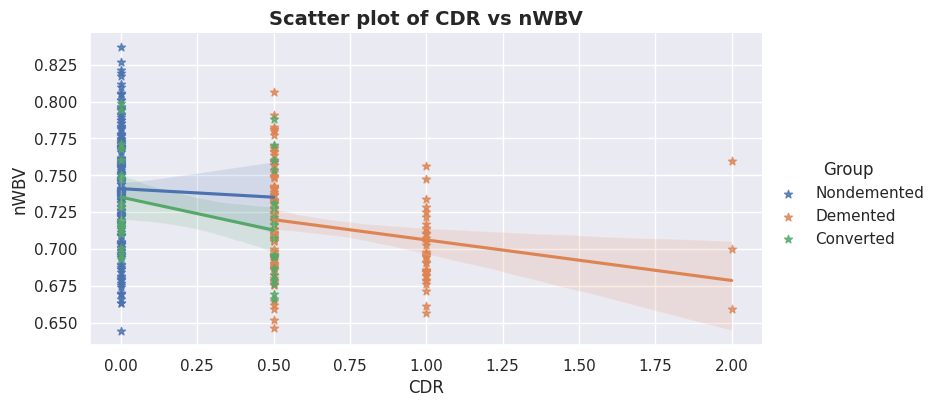

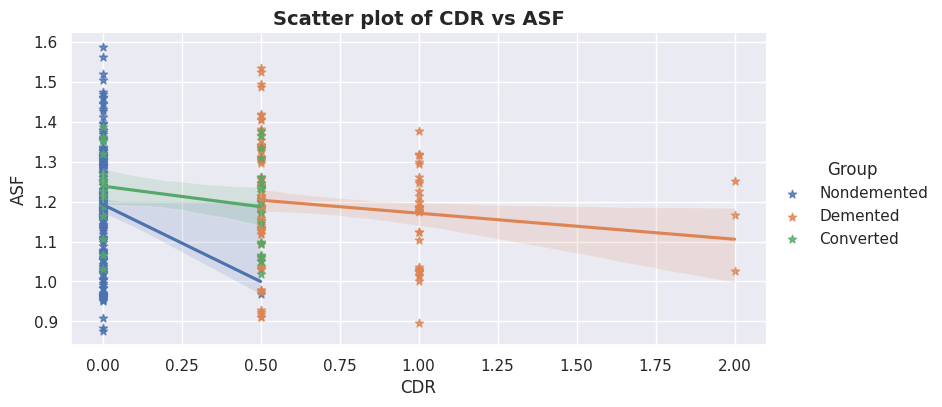

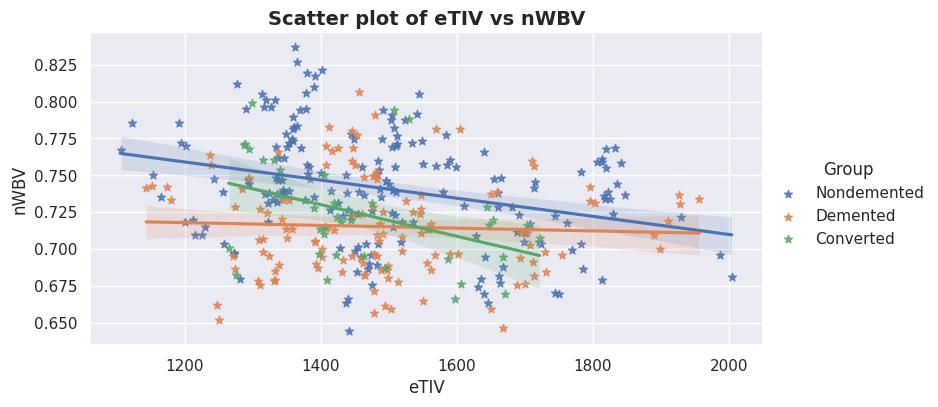

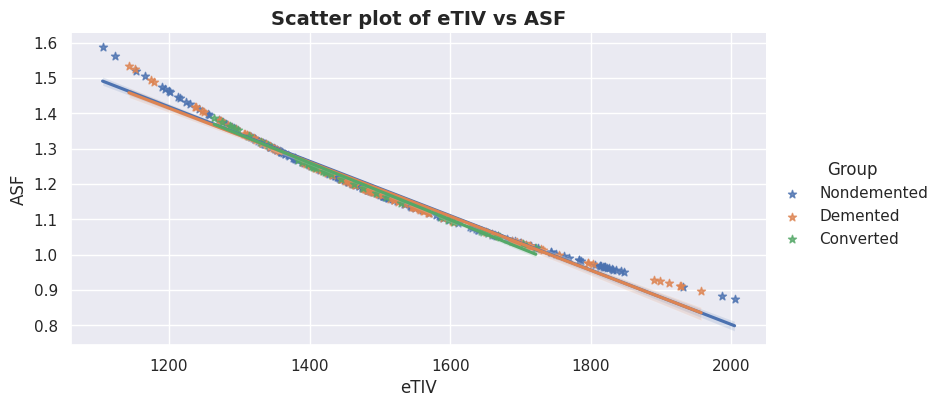

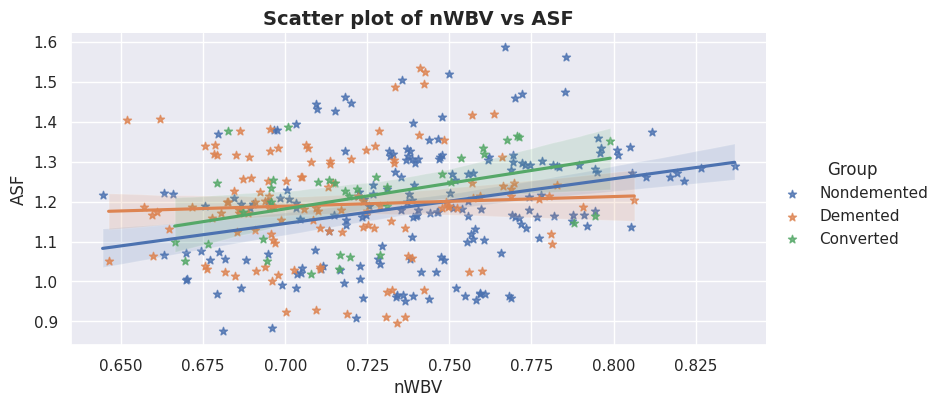

In [11]:
columns2 = ['Age', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF']

# Iterate over each pair of numeric columns
for i in range(len(columns2)):
    for j in range(i+1, len(columns2)):
        x_col = columns2[i]
        y_col = columns2[j]

        # Create an lmplot for each pair
        sns.lmplot(data=df_data_clean, x=x_col, y=y_col, markers='*', hue='Group', aspect=2, legend_out=True, height=4)
        plt.title(f'Scatter plot of {x_col} vs {y_col}')
        plt.show()

In [12]:
from typing import Tuple
import pandas as pd

def analyze_columns(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Analyze categorical and numerical columns in a DataFrame.

    Args:
        df: Input DataFrame

    Returns:
        Tuple containing:
        - Categorical analysis DataFrame
        - Numerical statistics DataFrame
    """
    # Analyze categorical columns
    cat_cols = df.select_dtypes(include='object').columns
    cat_analysis = pd.DataFrame([{
        'Column': col,
        'Unique Values': df[col].unique(),
        'Count of Unique Values': df[col].nunique(),
        'dtype': str(df[col].dtype)
    } for col in cat_cols])

    # Analyze numerical columns
    num_cols = df.select_dtypes(include='number').columns
    num_stats = df[num_cols].agg(['min', 'max', 'mean', 'std']).T.reset_index()
    num_stats.columns = ['Column', 'min', 'max', 'mean', 'standard deviation']

    return cat_analysis, num_stats

def filter_columns(df: pd.DataFrame, columns_to_keep: list) -> pd.DataFrame:
    """Filter DataFrame to retain specified columns."""
    return df[columns_to_keep]

def encode_labels(df: pd.DataFrame) -> pd.DataFrame:
    """
    Encode categorical labels to numerical values.

    Mapping:
    - 'M' -> 1, 'F' -> 0
    - 'Demented'/'Converted' -> 1, 'Nondemented' -> 0
    """
    mapping = {'M': 1, 'F': 0, 'Demented': 1, 'Converted': 1, 'Nondemented': 0}
    return df.replace({'Group': mapping, 'M/F': mapping})

# Execute analysis pipeline
cat_analysis, num_stats = analyze_columns(df_data_clean)


In [13]:
# Define columns to retain
RELEVANT_COLUMNS = ['Group', 'M/F', 'Age', 'MMSE', 'eTIV',
                   'nWBV', 'ASF', 'CDR', 'EDUC', 'SES']

# Process data
df_data3 = filter_columns(df_data_clean, RELEVANT_COLUMNS)
df_data4 = encode_labels(df_data3.copy())

In [14]:
df_data4

Group  M/F  Age  MMSE         eTIV      nWBV       ASF  CDR  EDUC  SES
0        0    1   87  27.0  1986.550000  0.696106  0.883440  0.0    14  2.0
1        0    1   88  30.0  2004.479526  0.681062  0.875539  0.0    14  2.0
5        0    0   88  28.0  1215.330000  0.709512  1.444060  0.0    18  3.0
6        0    0   90  27.0  1200.100000  0.718214  1.462380  0.0    18  3.0
7        0    1   80  28.0  1688.580000  0.711502  1.039330  0.0    12  4.0
..     ...  ...  ...   ...          ...       ...       ...  ...   ...  ...
368      1    1   82  28.0  1692.880000  0.693926  1.036690  0.5    16  1.0
369      1    1   86  26.0  1688.009649  0.675457  1.039686  0.5    16  1.0
370      0    0   61  30.0  1319.020000  0.801006  1.330540  0.0    13  2.0
371      0    0   63  30.0  1326.650000  0.795981  1.322890  0.0    13  2.0
372      0    0   65  30.0  1332.944463  0.801248  1.316634  0.0    13  2.0

[354 rows x 10 columns]

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

class MLWorkflow:
    def __init__(self, features, target, test_size=0.2, random_state=42):
        """
        Initialize machine learning workflow

        Args:
            features: DataFrame containing features
            target: Series containing target variable
            test_size: Proportion for test split
            random_state: Random seed for reproducibility
        """
        self.features = features
        self.target = target
        self.test_size = test_size
        self.random_state = random_state
        self.model = None
        self.X_test = None
        self.y_test = None
        self.y_pred = None
        self.y_proba = None

    def split_data(self):
        """Perform train-test split and store results as attributes"""
        (self.X_train, self.X_test,
         self.y_train, self.y_test) = train_test_split(
            self.features, self.target,
            test_size=self.test_size,
            random_state=self.random_state
        )
        return self

    def train_model(self, classifier=DecisionTreeClassifier(max_depth=4, random_state=8)):
        """Train specified classifier model"""
        self.model = classifier
        self.model.fit(self.X_train, self.y_train)
        return self

    def evaluate_performance(self, context_note=""):
        """Generate comprehensive performance evaluation"""
        if not self.model:
            raise ValueError("Model not trained - call train_model() first")

        self.y_pred = self.model.predict(self.X_test)
        self.y_proba = self.model.predict_proba(self.X_test)[:, 1]

        print(f"\n{context_note} Performance Evaluation:")
        print("\nClassification Report:")
        print(classification_report(self.y_test, self.y_pred))

        print("\nConfusion Matrix:")
        print(confusion_matrix(self.y_test, self.y_pred))

        roc_auc = roc_auc_score(self.y_test, self.y_proba)
        print(f"\nROC-AUC Score: {roc_auc:.2f}")

        return self

    def plot_roc_curve(self, context_note=""):
        """Plot ROC curve with custom styling"""
        fpr, tpr, _ = roc_curve(self.y_test, self.y_proba)
        roc_auc = roc_auc_score(self.y_test, self.y_proba)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2,
                 label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve {context_note}')
        plt.legend(loc="lower right")
        sns.despine()
        plt.show()


# Initialize workflow
workflow = MLWorkflow(
    features=df_data4.drop(columns=['Group', 'CDR']),
    target=df_data4['Group']
)


Baseline Model (Before Feature Interaction) Performance Evaluation:

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.86      0.81        37
           1       0.83      0.71      0.76        34

    accuracy                           0.79        71
   macro avg       0.79      0.79      0.79        71
weighted avg       0.79      0.79      0.79        71


Confusion Matrix:
[[32  5]
 [10 24]]

ROC-AUC Score: 0.82


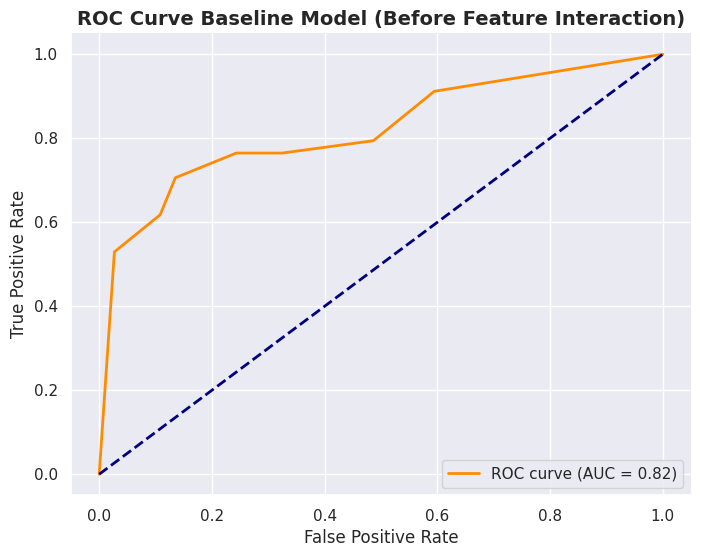

In [16]:
# Execute workflow
(workflow.split_data()
        .train_model()
        .evaluate_performance("Baseline Model (Before Feature Interaction)")
        .plot_roc_curve("Baseline Model (Before Feature Interaction)"))

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

class RegressionWorkflow:
    def __init__(self, features, target, test_size=0.2, random_state=42):
        """
        Initialize regression workflow

        Args:
            features: DataFrame containing features
            target: Series containing target variable
            test_size: Proportion for test split
            random_state: Random seed for reproducibility
        """
        self.features = features
        self.target = target
        self.test_size = test_size
        self.random_state = random_state
        self.model = None
        self.X_test = None
        self.y_test = None
        self.y_pred = None

    def split_data(self):
        """Perform train-test split and store results as attributes"""
        (self.X_train, self.X_test,
         self.y_train, self.y_test) = train_test_split(
            self.features, self.target,
            test_size=self.test_size,
            random_state=self.random_state
        )
        return self

    def train_model(self, regressor=DecisionTreeRegressor(max_depth=4, random_state=8)):
        """Train specified regression model"""
        self.model = regressor
        self.model.fit(self.X_train, self.y_train)
        return self

    def evaluate_performance(self, context_note=""):
        """Generate comprehensive regression performance evaluation"""
        if not self.model:
            raise ValueError("Model not trained - call train_model() first")

        self.y_pred = self.model.predict(self.X_test)

        print(f"\n{context_note} Performance Evaluation:")
        print(f"Mean Squared Error: {mean_squared_error(self.y_test, self.y_pred):.2f}")
        print(f"Mean Absolute Error: {mean_absolute_error(self.y_test, self.y_pred):.2f}")
        print(f"R² Score: {r2_score(self.y_test, self.y_pred):.2f}")

        return self

    def plot_residuals(self, context_note=""):
        """Plot residual analysis with enhanced visualization"""
        residuals = self.y_test - self.y_pred

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        sns.scatterplot(x=self.y_pred, y=residuals, alpha=0.6)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.title(f'Residual Plot {context_note}')

        plt.subplot(1, 2, 2)
        sns.histplot(residuals, kde=True)
        plt.xlabel('Residuals')
        plt.title('Residual Distribution')

        plt.tight_layout()
        sns.despine()
        plt.show()

        return self

    def plot_prediction_error(self, context_note=""):
        """Visualize actual vs predicted values"""
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=self.y_test, y=self.y_pred, alpha=0.6)
        plt.plot([self.y_test.min(), self.y_test.max()],
                 [self.y_test.min(), self.y_test.max()],
                 'r--', lw=2)
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title(f'Prediction Error Plot {context_note}')
        sns.despine()
        plt.show()

        return self


# Initialize regression workflow with CDR as target
cdr_workflow = RegressionWorkflow(
    features=df_data4.drop(columns=['CDR', 'Group']),
    target=df_data4['CDR']
)

In [18]:
# Execute workflow
(cdr_workflow.split_data()
            .train_model()
            .evaluate_performance("Baseline CDR Prediction"));
            # .plot_residuals("Baseline CDR Prediction")
            # .plot_prediction_error("Baseline CDR Prediction"))


Baseline CDR Prediction Performance Evaluation:
Mean Squared Error: 0.07
Mean Absolute Error: 0.18
R² Score: 0.46


In [19]:
df_data4

Group  M/F  Age  MMSE         eTIV      nWBV       ASF  CDR  EDUC  SES
0        0    1   87  27.0  1986.550000  0.696106  0.883440  0.0    14  2.0
1        0    1   88  30.0  2004.479526  0.681062  0.875539  0.0    14  2.0
5        0    0   88  28.0  1215.330000  0.709512  1.444060  0.0    18  3.0
6        0    0   90  27.0  1200.100000  0.718214  1.462380  0.0    18  3.0
7        0    1   80  28.0  1688.580000  0.711502  1.039330  0.0    12  4.0
..     ...  ...  ...   ...          ...       ...       ...  ...   ...  ...
368      1    1   82  28.0  1692.880000  0.693926  1.036690  0.5    16  1.0
369      1    1   86  26.0  1688.009649  0.675457  1.039686  0.5    16  1.0
370      0    0   61  30.0  1319.020000  0.801006  1.330540  0.0    13  2.0
371      0    0   63  30.0  1326.650000  0.795981  1.322890  0.0    13  2.0
372      0    0   65  30.0  1332.944463  0.801248  1.316634  0.0    13  2.0

[354 rows x 10 columns]

In [20]:
def generate_interaction_features(df):
    # Create a copy of the dataframe
    df_new = df.copy()

    # Research-backed interactions (supported by dementia literature)
    # 1. Age-related cognitive decline interactions
    df_new['Age_MMSE'] = df_new['Age'] * df_new['MMSE']  # Cognitive performance adjusted for age
    df_new['Age_nWBV'] = df_new['Age'] * df_new['nWBV']  # Brain volume loss with aging

    # 2. Education-related cognitive reserve interactions
    df_new['EDUC_MMSE'] = df_new['EDUC'] * df_new['MMSE']  # Education's protective effect on cognition
    df_new['EDUC_nWBV'] = df_new['EDUC'] * df_new['nWBV']  # Education-brain volume relationship

    # 3. Socioeconomic status interactions
    df_new['SES_MMSE'] = df_new['SES'] * df_new['MMSE']  # SES impact on cognitive performance
    df_new['SES_Age'] = df_new['SES'] * df_new['Age']     # SES-adjusted age effect

    # 4. Neuroimaging-cognition relationships
    df_new['nWBV_MMSE'] = df_new['nWBV'] * df_new['MMSE']  # Brain structure-cognition coupling
    df_new['eTIV_ASF'] = df_new['eTIV'] * df_new['ASF']    # Intracranial volume normalization

    # 5. Gender-specific interactions
    df_new['Gender_Age'] = df_new['M/F'] * df_new['Age']    # Gender-specific aging patterns
    df_new['Gender_MMSE'] = df_new['M/F'] * df_new['MMSE']  # Gender differences in cognitive scores

    # Novel clinically insightful interactions (hypothesis-driven)
    # 1. Brain volume adjusted for age and education
    df_new['Brain_Age_Edu'] = (df_new['nWBV'] / df_new['Age']) * df_new['EDUC']

    # 2. Composite cognitive-biological risk score
    df_new['Neuro_Risk'] = (df_new['Age']/100) * (1/df_new['nWBV']) * (1/df_new['MMSE'])

    # 3. Socioeconomic-brain health interaction
    df_new['SES_Brain'] = df_new['SES'] * (df_new['nWBV'] + df_new['ASF'])

    # 4. Education-adjusted brain maintenance
    df_new['Edu_Brain_Maintenance'] = df_new['EDUC'] * (df_new['nWBV'] / df_new['Age'])

    # 5. Multidimensional risk score
    df_new['Dementia_Risk_Index'] = (df_new['Age'] * df_new['eTIV']) / (df_new['MMSE'] * df_new['nWBV'] * df_new['EDUC'])

    return df_new

# Generate new features
df_data5 = generate_interaction_features(df_data4)

In [21]:
df_data5

Group  M/F  Age  MMSE         eTIV      nWBV       ASF  CDR  EDUC  SES  Age_MMSE   Age_nWBV  EDUC_MMSE  EDUC_nWBV  SES_MMSE  SES_Age  nWBV_MMSE     eTIV_ASF  Gender_Age  Gender_MMSE  Brain_Age_Edu  Neuro_Risk  SES_Brain  Edu_Brain_Maintenance  Dementia_Risk_Index
0        0    1   87  27.0  1986.550000  0.696106  0.883440  0.0    14  2.0    2349.0  60.561222      378.0   9.745484      54.0    174.0  18.794862  1754.997732          87         27.0       0.112017    0.046289   3.159092               0.112017           656.827876
1        0    1   88  30.0  2004.479526  0.681062  0.875539  0.0    14  2.0    2640.0  59.933456      420.0   9.534868      60.0    176.0  20.431860  1755.000000          88         30.0       0.108351    0.043070   3.113202               0.108351           616.663661
5        0    0   88  28.0  1215.330000  0.709512  1.444060  0.0    18  3.0    2464.0  62.437056      504.0  12.771216      84.0    264.0  19.866336  1755.009440           0          0.0       0.145127    0.044296   6.460716               0.145127           299.079475
6        0    0   90  27.0  1200.100000  0.718214  1.462380  0.0    18  3.0    2430.0  64.639260      486.0  12.927852      81.0    270.0  19.391778  1755.002238           0          0.0       0.143643    0.046411   6.541782               0.143643           309.435267
7        0    1   80  28.0  1688.580000  0.711502  1.039330  0.0    12  4.0    2240.0  56.920160      336.0   8.538024     112.0    320.0  19.922056  1754.991851          80         28.0       0.106725    0.040156   7.003328               0.106725           565.062160
..     ...  ...  ...   ...          ...       ...       ...  ...   ...  ...       ...        ...        ...        ...       ...      ...        ...          ...         ...          ...            ...         ...        ...                    ...                  ...
368      1    1   82  28.0  1692.880000  0.693926  1.036690  0.5    16  1.0    2296.0  56.901932      448.0  11.102816      28.0     82.0  19.429928  1754.991767          82         28.0       0.135400    0.042203   1.730616               0.135400           446.528160
369      1    1   86  26.0  1688.009649  0.675457  1.039686  0.5    16  1.0    2236.0  58.089302      416.0  10.807312      26.0     86.0  17.561882  1755.000000          86         26.0       0.125666    0.048970   1.715143               0.125666           516.633232
370      0    0   61  30.0  1319.020000  0.801006  1.330540  0.0    13  2.0    1830.0  48.861366      390.0  10.413078      60.0    122.0  24.030180  1755.008871           0          0.0       0.170706    0.025385   4.263092               0.170706           257.561437
371      0    0   63  30.0  1326.650000  0.795981  1.322890  0.0    13  2.0    1890.0  50.146803      390.0  10.347753      60.0    126.0  23.879430  1755.012019           0          0.0       0.164250    0.026383   4.237742               0.164250           269.233813
372      0    0   65  30.0  1332.944463  0.801248  1.316634  0.0    13  2.0    1950.0  52.081120      390.0  10.416224      60.0    130.0  24.037440  1755.000000           0          0.0       0.160250    0.027041   4.235764               0.160250           277.264231

[354 rows x 25 columns]


--- Classification Workflow with Interaction Features ---

Model with Interaction Features Performance Evaluation:

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.89      0.79        37
           1       0.83      0.59      0.69        34

    accuracy                           0.75        71
   macro avg       0.77      0.74      0.74        71
weighted avg       0.76      0.75      0.74        71


Confusion Matrix:
[[33  4]
 [14 20]]

ROC-AUC Score: 0.77


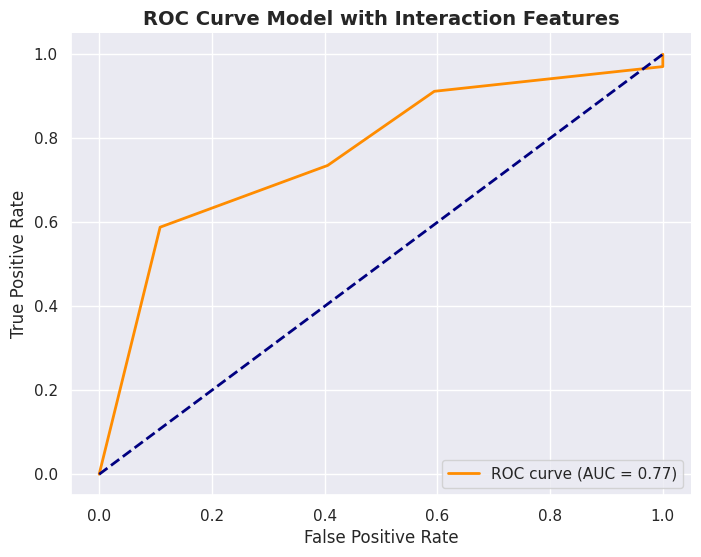

In [22]:
# Classification Workflow with Interaction Features (MLWorkflow)
workflow_interaction = MLWorkflow(
    features=df_data5.drop(columns=['Group', 'CDR']), # Use df_data5 and drop 'Group' and 'CDR' as features
    target=df_data5['Group'] # Target is still 'Group'
)

print("\n--- Classification Workflow with Interaction Features ---")
(workflow_interaction.split_data()
                      .train_model()
                      .evaluate_performance("Model with Interaction Features")
                      .plot_roc_curve("Model with Interaction Features"))



In [36]:
# Regression Workflow with Interaction Features (RegressionWorkflow)
cdr_workflow_interaction = RegressionWorkflow(
    features=df_data5.drop(columns=['CDR', 'Group']), # Use df_data5 and drop 'CDR' and 'Group' as features
    target=df_data5['CDR'] # Target is still 'CDR'
)

print("\n--- Regression Workflow with Interaction Features ---")
(cdr_workflow_interaction.split_data()
                         .train_model()
                         .evaluate_performance("CDR Prediction with Interaction Features"));
                         # .plot_residuals("CDR Prediction with Interaction Features") # Uncomment if you want to plot residuals
                         # .plot_prediction_error("CDR Prediction with Interaction Features")) # Uncomment if you want to plot prediction error


--- Regression Workflow with Interaction Features ---

CDR Prediction with Interaction Features Performance Evaluation:
Mean Squared Error: 0.06
Mean Absolute Error: 0.17
R² Score: 0.51



--- Evaluate Group Classification (Baseline Features) ---

--- Expert System Group Classification Evaluation ---

Confusion Matrix:
[[32  5]
 [10 24]]

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.86      0.81        37
           1       0.83      0.71      0.76        34

    accuracy                           0.79        71
   macro avg       0.79      0.79      0.79        71
weighted avg       0.79      0.79      0.79        71

Accuracy: 0.7887


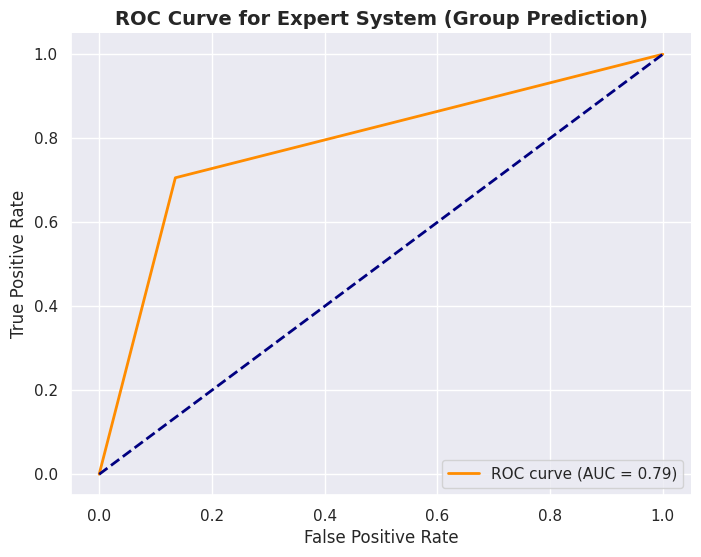

----------------------------------------

--- Evaluate Group Classification (Interaction Features) ---

--- Expert System Group Classification Evaluation ---

Confusion Matrix:
[[33  4]
 [14 20]]

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.89      0.79        37
           1       0.83      0.59      0.69        34

    accuracy                           0.75        71
   macro avg       0.77      0.74      0.74        71
weighted avg       0.76      0.75      0.74        71

Accuracy: 0.7465


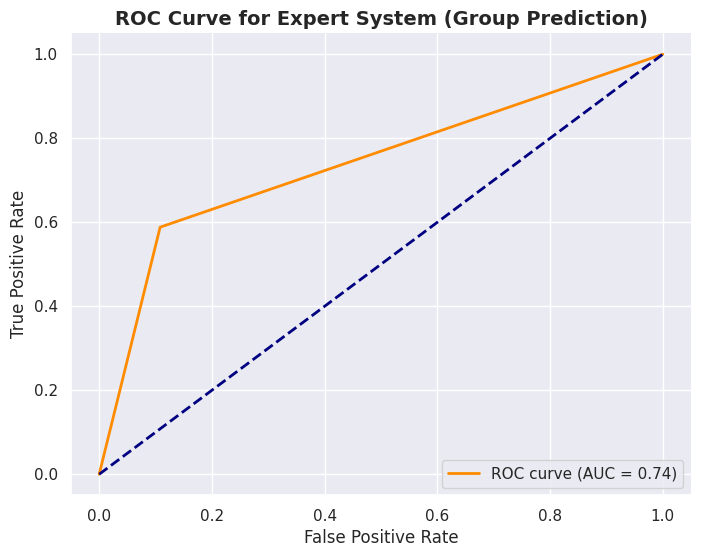

----------------------------------------


In [23]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Expert System for Group Prediction WITHOUT Interaction Features

class CDR_ExpertSystem_Group_Baseline_Classification:
    """
    Expert system for predicting 'Group' (Dementia vs. No Dementia)
    """
    def predict_group(self, data_point, provide_reasoning=False):
        """
        Predicts 'Group' (0 or 1) for a single data point

        Args:
            data_point (dict): Dictionary containing feature values (MMSE, Age, ASF, nWBV, M/F, EDUC, SES).
            provide_reasoning (bool, optional): If True, provides detailed reasoning for the prediction. Defaults to False.

        Returns:
            tuple: Predicted Group value (0 or 1) and optionally a list of reasoning steps if provide_reasoning is True.
        """
        reasoning = []
        mmse = data_point['MMSE']
        asf = data_point['ASF']
        age = data_point['Age']
        nwbv = data_point['nWBV']
        mf = data_point['M/F']
        educ = data_point['EDUC']
        ses = data_point['SES']

        if provide_reasoning:
            reasoning.append("Starting Group prediction based on expert system rules.")

        if mmse <= 27.50:
            if provide_reasoning:
                reasoning.append(f"Rule: MMSE ({mmse:.2f}) is less than or equal to 27.50.")
            if asf <= 0.97:
                if provide_reasoning:
                    reasoning.append(f"  Rule: ASF ({asf:.2f}) is less than or equal to 0.97.")
                if age <= 78.50:
                    if provide_reasoning:
                        reasoning.append(f"    Rule: Age ({age:.2f}) is less than or equal to 78.50. Prediction: Demented (1).")
                    return 1, reasoning if provide_reasoning else 1 # Class 1: Demented
                else: # Age > 78.50
                    if provide_reasoning:
                        reasoning.append(f"    Rule: Age ({age:.2f}) is greater than 78.50. Prediction: Nondemented (0).")
                    return 0, reasoning if provide_reasoning else 0 # Class 0: Nondemented
            else: # ASF > 0.97
                if provide_reasoning:
                    reasoning.append(f"  Rule: ASF ({asf:.2f}) is greater than 0.97.")
                if nwbv <= 0.81:
                    if provide_reasoning:
                        reasoning.append(f"    Rule: nWBV ({nwbv:.2f}) is less than or equal to 0.81.")
                    if mmse <= 26.50:
                        if provide_reasoning:
                            reasoning.append(f"      Rule: MMSE ({mmse:.2f}) is less than or equal to 26.50. Prediction: Demented (1).")
                        return 1, reasoning if provide_reasoning else 1 # Class 1: Demented
                    else: # MMSE > 26.50
                        if provide_reasoning:
                            reasoning.append(f"      Rule: MMSE ({mmse:.2f}) is greater than 26.50. Prediction: Demented (1).") # Note: Class 1 for MMSE > 26.50 also from rules
                        return 1, reasoning if provide_reasoning else 1 # Class 1: Demented
                else: # nWBV > 0.81
                    if provide_reasoning:
                        reasoning.append(f"    Rule: nWBV ({nwbv:.2f}) is greater than 0.81. Prediction: Nondemented (0).")
                    return 0, reasoning if provide_reasoning else 0 # Class 0: Nondemented
        else: # MMSE > 27.50
            if provide_reasoning:
                reasoning.append(f"Rule: MMSE ({mmse:.2f}) is greater than 27.50.")
            if mf <= 0.50: # M/F <= 0.50 (Female)
                if provide_reasoning:
                    reasoning.append(f"  Rule: M/F ({mf:.2f}) is less than or equal to 0.50 (Female).")
                if educ <= 12.50:
                    if provide_reasoning:
                        reasoning.append(f"    Rule: EDUC ({educ:.2f}) is less than or equal to 12.50.")
                    if mmse <= 28.50:
                        if provide_reasoning:
                            reasoning.append(f"      Rule: MMSE ({mmse:.2f}) is less than or equal to 28.50. Prediction: Demented (1).")
                        return 1, reasoning if provide_reasoning else 1 # Class 1: Demented
                    else: # MMSE > 28.50
                        if provide_reasoning:
                            reasoning.append(f"      Rule: MMSE ({mmse:.2f}) is greater than 28.50. Prediction: Nondemented (0).")
                        return 0, reasoning if provide_reasoning else 0 # Class 0: Nondemented
                else: # EDUC > 12.50
                    if provide_reasoning:
                        reasoning.append(f"    Rule: EDUC ({educ:.2f}) is greater than 12.50.")
                    if ses <= 1.50:
                        if provide_reasoning:
                            reasoning.append(f"      Rule: SES ({ses:.2f}) is less than or equal to 1.50. Prediction: Nondemented (0).")
                        return 0, reasoning if provide_reasoning else 0 # Class 0: Nondemented
                    else: # SES > 1.50
                        if provide_reasoning:
                            reasoning.append(f"      Rule: SES ({ses:.2f}) is greater than 1.50. Prediction: Nondemented (0).")
                        return 0, reasoning if provide_reasoning else 0 # Class 0: Nondemented
            else: # M/F > 0.50 (Male)
                if provide_reasoning:
                    reasoning.append(f"  Rule: M/F ({mf:.2f}) is greater than 0.50 (Male).")
                if asf <= 1.06:
                    if provide_reasoning:
                        reasoning.append(f"    Rule: ASF ({asf:.2f}) is less than or equal to 1.06.")
                    if age <= 66.00:
                        if provide_reasoning:
                            reasoning.append(f"      Rule: Age ({age:.2f}) is less than or equal to 66.00. Prediction: Demented (1).")
                        return 1, reasoning if provide_reasoning else 1 # Class 1: Demented
                    else: # Age > 66.00
                        if provide_reasoning:
                            reasoning.append(f"      Rule: Age ({age:.2f}) is greater than 66.00. Prediction: Nondemented (0).")
                        return 0, reasoning if provide_reasoning else 0 # Class 0: Nondemented
                else: # ASF > 1.06
                    if provide_reasoning:
                        reasoning.append(f"    Rule: ASF ({asf:.2f}) is greater than 1.06.")
                    if age <= 77.50:
                        if provide_reasoning:
                            reasoning.append(f"      Rule: Age ({age:.2f}) is less than or equal to 77.50. Prediction: Nondemented (0).")
                        return 0, reasoning if provide_reasoning else 0 # Class 0: Nondemented
                    else: # Age > 77.50
                        if provide_reasoning:
                            reasoning.append(f"      Rule: Age ({age:.2f}) is greater than 77.50. Prediction: Demented (1).")
                        return 1, reasoning if provide_reasoning else 1 # Class 1: Demented
        return 0, ["No rule matched"] if provide_reasoning else 0 # Default Nondemented

    def format_data_point(self, df_row):
        """Formats DataFrame row to dictionary for baseline features."""
        return {
            'MMSE': df_row['MMSE'],
            'Age': df_row['Age'],
            'ASF': df_row['ASF'],
            'nWBV': df_row['nWBV'],
            'M/F': df_row['M/F'],
            'EDUC': df_row['EDUC'],
            'SES': df_row['SES']
        }

# Expert System for Group Prediction WITH Interaction Features

class CDR_ExpertSystem_Group_InteractionFeatures_Classification:
    """
    Expert system for predicting 'Group' (Dementia vs. No Dementia)
    based on decision rules derived from a classification
    (WITH feature interactions).
    """
    def predict_group(self, data_point, provide_reasoning=False):
        """
        Predicts 'Group' (0 or 1) using interaction features.

        Args:
            data_point (dict): Dictionary containing feature values, including interaction features.
            provide_reasoning (bool, optional): If True, provides detailed reasoning.

        Returns:
            tuple: Predicted Group value (0 or 1) and reasoning steps.
        """
        reasoning = []
        mmse = data_point['MMSE']
        gender_mmse = data_point['Gender_MMSE']
        age_nwbv = data_point['Age_nWBV']
        ses_brain = data_point['SES_Brain']
        etiv = data_point['eTIV']
        asf = data_point['ASF']
        nwbv_mmse = data_point['nWBV_MMSE']
        educ_nwbv = data_point['EDUC_nWBV']
        ses_mmse = data_point['SES_MMSE']
        etiv_asf = data_point['eTIV_ASF']


        if provide_reasoning:
            reasoning.append("Starting Group prediction using interaction feature rules.")

        if mmse <= 27.50:
            if provide_reasoning:
                reasoning.append(f"Rule: MMSE ({mmse:.2f}) is less than or equal to 27.50.")
            if gender_mmse <= 26.50:
                if provide_reasoning:
                    reasoning.append(f"  Rule: Gender_MMSE ({gender_mmse:.2f}) is less than or equal to 26.50.")
                if age_nwbv <= 64.94:
                    if provide_reasoning:
                        reasoning.append(f"    Rule: Age_nWBV ({age_nwbv:.2f}) is less than or equal to 64.94. Prediction: Demented (1).")
                    return 1, reasoning if provide_reasoning else 1 # Class 1: Demented
                else: # Age_nWBV > 64.94
                    if provide_reasoning:
                        reasoning.append(f"    Rule: Age_nWBV ({age_nwbv:.2f}) is greater than 64.94.")
                    if ses_brain <= 5.05:
                        if provide_reasoning:
                            reasoning.append(f"      Rule: SES_Brain ({ses_brain:.2f}) is less than or equal to 5.05. Prediction: Demented (1).")
                        return 1, reasoning if provide_reasoning else 1 # Class 1: Demented
                    else: # SES_Brain > 5.05
                        if provide_reasoning:
                            reasoning.append(f"      Rule: SES_Brain ({ses_brain:.2f}) is greater than 5.05. Prediction: Nondemented (0).")
                        return 0, reasoning if provide_reasoning else 0 # Class 0: Nondemented
            else: # Gender_MMSE > 26.50
                if provide_reasoning:
                    reasoning.append(f"  Rule: Gender_MMSE ({gender_mmse:.2f}) is greater than 26.50.")
                if etiv <= 1607.40:
                    if provide_reasoning:
                        reasoning.append(f"    Rule: eTIV ({etiv:.2f}) is less than or equal to 1607.40.")
                    if asf <= 1.26:
                        if provide_reasoning:
                            reasoning.append(f"      Rule: ASF ({asf:.2f}) is less than or equal to 1.26. Prediction: Demented (1).")
                        return 1, reasoning if provide_reasoning else 1 # Class 1: Demented
                    else: # ASF > 1.26
                        if provide_reasoning:
                            reasoning.append(f"      Rule: ASF ({asf:.2f}) is greater than 1.26. Prediction: Nondemented (0).")
                        return 0, reasoning if provide_reasoning else 0 # Class 0: Nondemented
                else: # eTIV > 1607.40
                    if provide_reasoning:
                        reasoning.append(f"    Rule: eTIV ({etiv:.2f}) is greater than 1607.40. Prediction: Nondemented (0).")
                    return 0, reasoning if provide_reasoning else 0 # Class 0: Nondemented
        else: # MMSE > 27.50
            if provide_reasoning:
                reasoning.append(f"Rule: MMSE ({mmse:.2f}) is greater than 27.50.")
            if nwbv_mmse <= 22.03:
                if provide_reasoning:
                    reasoning.append(f"  Rule: nWBV_MMSE ({nwbv_mmse:.2f}) is less than or equal to 22.03.")
                if ses_brain <= 1.64:
                    if provide_reasoning:
                        reasoning.append(f"    Rule: SES_Brain ({ses_brain:.2f}) is less than or equal to 1.64. Prediction: Demented (1).")
                    return 1, reasoning if provide_reasoning else 1 # Class 1: Demented
                else: # SES_Brain > 1.64
                    if provide_reasoning:
                        reasoning.append(f"    Rule: SES_Brain ({ses_brain:.2f}) is greater than 1.64.")
                    if educ_nwbv <= 11.73:
                        if provide_reasoning:
                            reasoning.append(f"      Rule: EDUC_nWBV ({educ_nwbv:.2f}) is less than or equal to 11.73. Prediction: Nondemented (0).")
                        return 0, reasoning if provide_reasoning else 0 # Class 0: Nondemented
                    else: # EDUC_nWBV > 11.73
                        if provide_reasoning:
                            reasoning.append(f"      Rule: EDUC_nWBV ({educ_nwbv:.2f}) is greater than 11.73. Prediction: Nondemented (0).")
                        return 0, reasoning if provide_reasoning else 0 # Class 0: Nondemented
            else: # nWBV_MMSE > 22.03
                if provide_reasoning:
                    reasoning.append(f"  Rule: nWBV_MMSE ({nwbv_mmse:.2f}) is greater than 22.03.")
                if ses_mmse <= 29.50:
                    if provide_reasoning:
                        reasoning.append(f"    Rule: SES_MMSE ({ses_mmse:.2f}) is less than or equal to 29.50. Prediction: Demented (1).")
                    return 1, reasoning if provide_reasoning else 1 # Class 1: Demented
                else: # SES_MMSE > 29.50
                    if provide_reasoning:
                        reasoning.append(f"    Rule: SES_MMSE ({ses_mmse:.2f}) is greater than 29.50.")
                    if etiv_asf <= 1755.01:
                        if provide_reasoning:
                            reasoning.append(f"      Rule: eTIV_ASF ({etiv_asf:.2f}) is less than or equal to 1755.01. Prediction: Nondemented (0).")
                        return 0, reasoning if provide_reasoning else 0 # Class 0: Nondemented
                    else: # eTIV_ASF > 1755.01
                        if provide_reasoning:
                            reasoning.append(f"      Rule: eTIV_ASF ({etiv_asf:.2f}) is greater than 1755.01. Prediction: Nondemented (0).")
                        return 0, reasoning if provide_reasoning else 0 # Class 0: Nondemented
        return 0, ["No rule matched"] if provide_reasoning else 0 # Default Nondemented

    def format_data_point(self, df_row):
        """Formats DataFrame row to dictionary for interaction features."""
        return {
            'MMSE': df_row['MMSE'],
            'Age': df_row['Age'],
            'ASF': df_row['ASF'],
            'nWBV': df_row['nWBV'],
            'M/F': df_row['M/F'],
            'EDUC': df_row['EDUC'],
            'SES': df_row['SES'],
            'Gender_MMSE': df_row['Gender_MMSE'],
            'Age_nWBV': df_row['Age_nWBV'],
            'SES_Brain': df_row['SES_Brain'],
            'eTIV': df_row['eTIV'],
            'nWBV_MMSE': df_row['nWBV_MMSE'],
            'EDUC_nWBV': df_row['EDUC_nWBV'],
            'SES_MMSE': df_row['SES_MMSE'],
            'eTIV_ASF': df_row['eTIV_ASF'],
        }


def evaluate_expert_system_group_classification(expert_system, X_test, y_test):
    """
    Evaluates expert system for binary classification of 'Group'.

    Args:
        expert_system (CDR_ExpertSystem_Group_Baseline_Classification or CDR_ExpertSystem_Group_InteractionFeatures_Classification):
            Expert system instance for Group prediction.
        X_test (pd.DataFrame): DataFrame of test features.
        y_test (pd.Series): Series of true test 'Group' values.

    Returns:
        None: Prints classification metrics, confusion matrix, and ROC curve.
    """
    true_labels_binary = list(y_test) # Assuming y_test is already binary (0 or 1)
    predicted_labels_binary = []
    predicted_probabilities = [] # Store probabilities for ROC curve

    X_test_reset_index = X_test.reset_index(drop=True)

    for index, row in X_test_reset_index.iterrows():
        data_point = expert_system.format_data_point(row)
        predicted_group, _ = expert_system.predict_group(data_point, provide_reasoning=False)
        predicted_labels_binary.append(predicted_group)
        # Expert system gives discrete predictions, for ROC, we'd ideally have probabilities.
        # As a simplification, let's use the predicted label (0 or 1) as probability for ROC AUC calculation.
        predicted_probabilities.append(predicted_group) # Using binary prediction as probability


    print(f"\n--- Expert System Group Classification Evaluation ---")

    print("\nConfusion Matrix:")
    cm = confusion_matrix(true_labels_binary, predicted_labels_binary)
    print(cm)

    print("\nClassification Report:")
    print(classification_report(true_labels_binary, predicted_labels_binary))

    accuracy = accuracy_score(true_labels_binary, predicted_labels_binary)
    print(f"Accuracy: {accuracy:.4f}")

    # ROC Curve and AUC
    fpr, tpr, thresholds = roc_curve(true_labels_binary, predicted_probabilities) # Use binary predictions as probabilities
    roc_auc = roc_auc_score(true_labels_binary, predicted_probabilities)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Expert System (Group Prediction)')
    plt.legend(loc="lower right")
    sns.despine()
    plt.show()

    print("-" * 40) # Separator


# Instantiate and Evaluate Expert System for Group Prediction WITHOUT Interaction Features
cdr_expert_system_group_baseline = CDR_ExpertSystem_Group_Baseline_Classification()

print("\n--- Evaluate Group Classification (Baseline Features) ---")
evaluate_expert_system_group_classification(cdr_expert_system_group_baseline, workflow.X_test, workflow.y_test)


# Instantiate and Evaluate Expert System for Group Prediction WITH Interaction Features
cdr_expert_system_group_interaction = CDR_ExpertSystem_Group_InteractionFeatures_Classification()

print("\n--- Evaluate Group Classification (Interaction Features) ---")
evaluate_expert_system_group_classification(cdr_expert_system_group_interaction, workflow_interaction.X_test, workflow_interaction.y_test)


In [28]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

class CDR_ExpertSystem_Baseline_Reasoning:
    """
    Expert system for predicting Clinical Dementia Rating (CDR) with enhanced reasoning output.
    """
    def predict_cdr(self, data_point, provide_reasoning=False):
        """
        Predicts CDR and provides detailed, transparent reasoning.

        Args:
            data_point (dict): Feature values (MMSE, Age, EDUC, nWBV, ASF, M/F, SES).
            provide_reasoning (bool, optional): If True, provides detailed reasoning.

        Returns:
            tuple: Predicted CDR value, diagnosis string, and optionally reasoning steps.
        """
        reasoning = []
        diagnosis = ""
        numerical_score = None

        mmse = data_point['MMSE']
        age = data_point['Age']
        educ = data_point['EDUC']
        nwbv = data_point['nWBV']
        asf = data_point['ASF']
        mf = data_point['M/F']
        ses = data_point['SES']

        if provide_reasoning:
            reasoning.append("Starting CDR evaluation process...")

        if mmse <= 27.50:
            if provide_reasoning:
                reasoning.append(f"- MMSE score of {mmse:.2f} is below or at the threshold (<= 27.50), indicating potential cognitive concern.")
            if mmse <= 23.50:
                if provide_reasoning:
                    reasoning.append(f"  - MMSE score further decreases to {mmse:.2f} (<= 23.50), suggesting significant cognitive decline.")
                if age <= 94.00:
                    if provide_reasoning:
                        reasoning.append(f"    - Patient's age is {age:.0f}, within the typical assessment range (<= 94 years).")
                    if mmse <= 15.50:
                        numerical_score = 1.33
                        diagnosis = "Moderate to Severe Impairment Likely"
                        if provide_reasoning:
                            reasoning.append(f"      - Critically low MMSE score of {mmse:.2f} (<= 15.50) strongly suggests severe cognitive impairment.")
                    else: # MMSE > 15.50
                        numerical_score = 0.79
                        diagnosis = "Mild to Moderate Impairment Possible"
                        if provide_reasoning:
                            reasoning.append(f"      - MMSE score is {mmse:.2f} (between 15.50 and 23.50), indicating moderate cognitive impairment.")
                else: # Age > 94.00
                    numerical_score = 2.00
                    diagnosis = "Severe Impairment Highly Probable (Very Advanced Age)"
                    if provide_reasoning:
                        reasoning.append(f"    - Patient is older than 94 years ({age:.0f} years), combined with low MMSE, severe impairment is highly probable.")
            else: # MMSE > 23.50
                if provide_reasoning:
                    reasoning.append(f"  - MMSE score is {mmse:.2f} (between 23.50 and 27.50), indicating mild cognitive concern.")
                if educ <= 19.00:
                    if provide_reasoning:
                        reasoning.append(f"    - Education level is {educ:.0f} years (<= 19 years).")
                    if nwbv <= 0.76:
                        numerical_score = 0.52
                        diagnosis = "Mild Impairment Possible (Reduced Brain Volume)"
                        if provide_reasoning:
                            reasoning.append(f"      - Normalized Whole Brain Volume (nWBV) is {nwbv:.3f} (<= 0.76), suggesting reduced brain volume.")
                    else: # nWBV > 0.76
                        numerical_score = 0.30
                        diagnosis = "Very Mild Impairment or Questionable Dementia" # Closer to normal
                        if provide_reasoning:
                            reasoning.append(f"      - nWBV is {nwbv:.3f} (> 0.76), brain volume reduction less pronounced in this sub-group.")
                else: # EDUC > 19.00
                    if provide_reasoning:
                        reasoning.append(f"    - Education level is higher, {educ:.0f} years (> 19 years), potentially indicating cognitive reserve.")
                    if nwbv <= 0.75:
                        numerical_score = 0.50
                        diagnosis = "Mild Impairment Possible (Despite Higher Education)"
                        if provide_reasoning:
                            reasoning.append(f"      - nWBV is {nwbv:.3f} (<= 0.75), reduced brain volume still a factor despite higher education.")
                    else: # nWBV > 0.75
                        numerical_score = 2.00 # This seems like an anomaly in original rules - should double check. Original tree outputted 2.00
                        diagnosis = "Severe Impairment - Rule Anomaly (Check Tree)" # Anomaly, review rule derivation.
                        if provide_reasoning:
                            reasoning.append(f"      - nWBV is {nwbv:.3f} (> 0.75), unexpectedly leading to a severe impairment outcome based on rule set. Review needed.")

        else: # MMSE > 27.50
            if provide_reasoning:
                reasoning.append(f"- High MMSE score of {mmse:.2f} (> 27.50) generally indicates preserved cognitive function.")
            if mf <= 0.50: # M/F <= 0.50 (Female)
                if provide_reasoning:
                    reasoning.append(f"  - Patient is female (M/F = {mf:.2f}), applying gender-specific criteria.")
                if educ <= 12.50:
                    if provide_reasoning:
                        reasoning.append(f"    - Education level is {educ:.0f} years (<= 12.50).")
                    if age <= 72.00:
                        numerical_score = 0.42
                        diagnosis = "Very Mild Impairment Possible (Lower Education)"
                        if provide_reasoning:
                            reasoning.append(f"      - Age is {age:.0f} (<= 72 years), combined with lower education, slight impairment possible.")
                    else: # Age > 72.00
                        numerical_score = 0.07
                        diagnosis = "Likely Normal Cognition (Elderly Female, High MMSE)"
                        if provide_reasoning:
                            reasoning.append(f"      - Age is {age:.0f} (> 72 years), but high MMSE suggests likely normal cognition for elderly females.")
                else: # EDUC > 12.50
                    if provide_reasoning:
                        reasoning.append(f"    - Education level is higher, {educ:.0f} years (> 12.50).")
                    if asf <= 1.42:
                        numerical_score = 0.02
                        diagnosis = "Highly Likely Normal Cognition"
                        if provide_reasoning:
                            reasoning.append(f"      - Atlas Scaling Factor (ASF) is {asf:.3f} (<= 1.42), further supporting normal cognition.")
                    else: # ASF > 1.42
                        numerical_score = 0.12
                        diagnosis = "Very Likely Normal Cognition"
                        if provide_reasoning:
                            reasoning.append(f"      - ASF is {asf:.3f} (> 1.42), still likely normal, but slightly less certain than with lower ASF.")
            else: # M/F > 0.50 (Male)
                if provide_reasoning:
                    reasoning.append(f"  - Patient is male (M/F = {mf:.2f}), applying gender-specific criteria.")
                if asf <= 0.94:
                    if provide_reasoning:
                        reasoning.append(f"    - ASF is {asf:.3f} (<= 0.94).")
                    if ses <= 1.50:
                        numerical_score = 0.62
                        diagnosis = "Mild Impairment Possible (Lower SES)"
                        if provide_reasoning:
                            reasoning.append(f"      - Socioeconomic Status (SES) is {ses:.0f} (<= 1.50), suggesting socioeconomic factors might contribute to slight impairment.")
                    else: # SES > 1.50
                        numerical_score = 0.00
                        diagnosis = "Highly Likely Normal Cognition (Male, High MMSE, Good ASF)"
                        if provide_reasoning:
                            reasoning.append(f"      - SES is {ses:.0f} (> 1.50), combined with male gender, high MMSE and good ASF, highly likely normal.")
                else: # ASF > 0.94
                    if provide_reasoning:
                        reasoning.append(f"    - ASF is {asf:.3f} (> 0.94).")
                    if asf <= 1.02:
                        numerical_score = 0.05
                        diagnosis = "Very Likely Normal Cognition (Slightly Elevated ASF)"
                        if provide_reasoning:
                            reasoning.append(f"      - ASF is {asf:.3f} (<= 1.02), slightly elevated ASF, but still very likely normal.")
                    else: # ASF > 1.02
                        numerical_score = 0.21
                        diagnosis = "Likely Normal Cognition (Moderately Elevated ASF)"
                        if provide_reasoning:
                            reasoning.append(f"      - ASF is {asf:.3f} (> 1.02), moderately elevated ASF, but still likely within normal range given other factors.")

        return numerical_score, diagnosis, reasoning if provide_reasoning else (numerical_score, diagnosis)

    def format_data_point(self, df_row):
        """Formats DataFrame row to dictionary."""
        return {
            'MMSE': df_row['MMSE'],
            'Age': df_row['Age'],
            'EDUC': df_row['EDUC'],
            'nWBV': df_row['nWBV'],
            'ASF': df_row['ASF'],
            'M/F': df_row['M/F'],
            'SES': df_row['SES']
        }


In [30]:
def evaluate_expert_system_classification(expert_system, X_test, y_test, threshold):
    """
    Evaluates expert system for binary classification based on a CDR threshold.

    Args:
        expert_system (CDR_ExpertSystem_Baseline_Reasoning): Expert system instance.
        X_test (pd.DataFrame): DataFrame of test features.
        y_test (pd.Series): Series of true test CDR values.
        threshold (float): Threshold value to classify predicted CDR.

    Returns:
        None: Prints classification metrics.
    """
    true_labels_binary = []
    predicted_labels_binary = []
    predicted_cdr_values = [] # To store predicted CDR values for analysis

    X_test_reset_index = X_test.reset_index(drop=True)

    for index, row in X_test_reset_index.iterrows():
        data_point = expert_system.format_data_point(row)
        predicted_cdr, _, _ = expert_system.predict_cdr(data_point, provide_reasoning=False)
        predicted_cdr_values.append(predicted_cdr) # Store predicted CDR

        # Binary classification based on threshold: CDR > 0.2 as 'Dementia' (Positive Class - 1), CDR <= 0.2 as 'No Dementia' (Negative Class - 0)
        predicted_label = 1 if predicted_cdr >= threshold else 0
        predicted_labels_binary.append(predicted_label)

        # Convert actual CDR to binary labels: CDR > 0 as 'Dementia' (1), CDR == 0 as 'No Dementia' (0)
        actual_label = 1 if y_test.iloc[index] > 0 else 0 # Consider CDR > 0 as positive class (Dementia)
        true_labels_binary.append(actual_label)

    print(f"\n--- Expert System Classification Evaluation (Threshold = {threshold}) ---")

    print("\nConfusion Matrix:")
    cm = confusion_matrix(true_labels_binary, predicted_labels_binary)
    print(cm)

    print("\nClassification Report:")
    print(classification_report(true_labels_binary, predicted_labels_binary))

    accuracy = accuracy_score(true_labels_binary, predicted_labels_binary)
    print(f"Accuracy: {accuracy:.4f}")

    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) != 0 else 0 # To avoid division by zero
    print(f"Specificity: {specificity:.4f}") # Specificity (True Negative Rate)

    print("-" * 40) # Separator

# Instantiate the enhanced Expert System
cdr_expert_system_reasoning = CDR_ExpertSystem_Baseline_Reasoning()

# Evaluate classification performance for different thresholds
thresholds_to_test = [0.25, 0.5, 0.7]

for threshold in thresholds_to_test:
    evaluate_expert_system_classification(cdr_expert_system_reasoning, cdr_workflow.X_test, cdr_workflow.y_test, threshold)


--- Expert System Classification Evaluation (Threshold = 0.25) ---

Confusion Matrix:
[[35  5]
 [10 21]]

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.88      0.82        40
           1       0.81      0.68      0.74        31

    accuracy                           0.79        71
   macro avg       0.79      0.78      0.78        71
weighted avg       0.79      0.79      0.79        71

Accuracy: 0.7887
Specificity: 0.8750
----------------------------------------

--- Expert System Classification Evaluation (Threshold = 0.5) ---

Confusion Matrix:
[[37  3]
 [11 20]]

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.93      0.84        40
           1       0.87      0.65      0.74        31

    accuracy                           0.80        71
   macro avg       0.82      0.79      0.79        71
weighted avg       0.81      0.80      0.80        71

Accuracy:

In [31]:
def output_actual_vs_predicted_cdr(expert_system, X_test, y_test):
    """
    Outputs a formatted list of actual vs. predicted CDR values for each data point in X_test.

    Args:
        expert_system (CDR_ExpertSystem_Baseline or CDR_ExpertSystem_Baseline_Reasoning):
            Instance of the expert system.
        X_test (pd.DataFrame): DataFrame of test features.
        y_test (pd.Series): Series of true test CDR values.
    """
    X_test_reset_index = X_test.reset_index(drop=True) # Reset index for consistent iteration

    print("Actual vs. Predicted CDR for each data point:")
    for index, row in X_test_reset_index.iterrows():
        data_point = expert_system.format_data_point(row)
        predicted_cdr, _, _ = expert_system.predict_cdr(data_point, provide_reasoning=False) # Get prediction

        actual_cdr = y_test.iloc[index] # Get actual CDR
        print(f"Data point {index}: Actual CDR = {actual_cdr}, Predicted CDR = {predicted_cdr:.2f}")

#reasoning expert system and test data from cdr_workflow
output_actual_vs_predicted_cdr(cdr_expert_system_reasoning, cdr_workflow.X_test, cdr_workflow.y_test)

Actual vs. Predicted CDR for each data point:
Data point 0: Actual CDR = 0.0, Predicted CDR = 0.05
Data point 1: Actual CDR = 0.0, Predicted CDR = 0.42
Data point 2: Actual CDR = 0.5, Predicted CDR = 0.02
Data point 3: Actual CDR = 0.0, Predicted CDR = 0.21
Data point 4: Actual CDR = 0.0, Predicted CDR = 0.02
Data point 5: Actual CDR = 0.5, Predicted CDR = 0.02
Data point 6: Actual CDR = 0.0, Predicted CDR = 0.02
Data point 7: Actual CDR = 0.0, Predicted CDR = 0.02
Data point 8: Actual CDR = 0.0, Predicted CDR = 0.02
Data point 9: Actual CDR = 0.0, Predicted CDR = 0.30
Data point 10: Actual CDR = 1.0, Predicted CDR = 0.79
Data point 11: Actual CDR = 0.5, Predicted CDR = 0.21
Data point 12: Actual CDR = 0.5, Predicted CDR = 0.52
Data point 13: Actual CDR = 1.0, Predicted CDR = 0.79
Data point 14: Actual CDR = 0.5, Predicted CDR = 0.21
Data point 15: Actual CDR = 0.0, Predicted CDR = 0.21
Data point 16: Actual CDR = 0.0, Predicted CDR = 0.07
Data point 17: Actual CDR = 0.0, Predicted CDR

In [32]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns


import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

class CDR_ExpertSystem_InteractionFeatures_Reasoning:
    """
    Expert system for predicting Clinical Dementia Rating (CDR)
    """
    def predict_cdr(self, data_point, provide_reasoning=False):
        """
        Predicts CDR and provides detailed, transparent reasoning, using interaction features.

        Args:
            data_point (dict): Feature values, including interaction features.
            provide_reasoning (bool, optional): If True, provides detailed reasoning.

        Returns:
            tuple: Predicted CDR value, diagnosis string, and optionally reasoning steps.
        """
        reasoning = []
        diagnosis = ""
        numerical_score = None

        mmse = data_point['MMSE']
        neuro_risk = data_point['Neuro_Risk']
        educ_nwbv = data_point['EDUC_nWBV']
        ses_brain = data_point['SES_Brain']
        ses_age = data_point['SES_Age']
        gender_age = data_point['Gender_Age']
        etiv = data_point['eTIV']


        if provide_reasoning:
            reasoning.append("Starting CDR evaluation process using interaction feature rules...")

        if mmse <= 27.50:
            if provide_reasoning:
                reasoning.append(f"- MMSE score of {mmse:.2f} is below or at the threshold (<= 27.50), indicating potential cognitive concern.")
            if neuro_risk <= 0.07:
                if provide_reasoning:
                    reasoning.append(f"  - Neuro_Risk score ({neuro_risk:.2f}) is low (<= 0.07).")
                if educ_nwbv <= 15.16:
                    if provide_reasoning:
                        reasoning.append(f"    - EDUC_nWBV interaction feature ({educ_nwbv:.2f}) is below or at the threshold (<= 15.16).")
                    if mmse <= 23.50:
                        numerical_score = 0.79
                        diagnosis = "Mild Impairment Likely"
                        if provide_reasoning:
                            reasoning.append(f"      - MMSE score is {mmse:.2f} (<= 23.50), suggesting mild impairment in this risk subgroup.")
                    else: # MMSE > 23.50
                        numerical_score = 0.47
                        diagnosis = "Very Mild Impairment Possible"
                        if provide_reasoning:
                            reasoning.append(f"      - MMSE score is {mmse:.2f} (> 23.50), indicating very mild impairment in this lower risk subgroup.")
                    pass
                else: # EDUC_nWBV > 15.16
                    numerical_score = 2.00
                    diagnosis = "Severe Impairment Likely (Low Neuro_Risk, High EDUC_nWBV - Rule Anomaly)" # Unusual rule outcome
                    if provide_reasoning:
                        reasoning.append(f"    - EDUC_nWBV interaction feature ({educ_nwbv:.2f}) is high (> 15.16), unexpectedly suggesting severe impairment. Review rule derivation.")
            else: # Neuro_Risk > 0.07
                if provide_reasoning:
                    reasoning.append(f"  - Neuro_Risk score ({neuro_risk:.2f}) is elevated (> 0.07).")
                if ses_brain <= 1.77:
                    numerical_score = 1.00
                    diagnosis = "Mild to Moderate Impairment"
                    if provide_reasoning:
                        reasoning.append(f"    - SES_Brain interaction feature ({ses_brain:.2f}) is low (<= 1.77), indicating mild to moderate impairment in higher risk group.")
                else: # SES_Brain > 1.77
                    numerical_score = 2.00
                    diagnosis = "Severe Impairment Likely (High Neuro_Risk & SES_Brain)"
                    if provide_reasoning:
                        reasoning.append(f"    - SES_Brain interaction feature ({ses_brain:.2f}) is high (> 1.77), combined with high Neuro_Risk, suggests severe impairment.")
        else: # MMSE > 27.50
            if provide_reasoning:
                reasoning.append(f"- High MMSE score of {mmse:.2f} (> 27.50) generally indicates preserved cognitive function.")
            if ses_brain <= 1.64:
                if provide_reasoning:
                    reasoning.append(f"  - SES_Brain interaction feature ({ses_brain:.2f}) is low (<= 1.64).")
                if ses_age <= 61.50:
                    numerical_score = 1.00 # Rule anomaly - high MMSE, low SES_Brain/SES_Age -> Impairment?
                    diagnosis = "Unexpected Impairment Indication (High MMSE, Low SES_Brain/SES_Age - Rule Anomaly)" # Rule might need review
                    if provide_reasoning:
                        reasoning.append(f"    - SES_Age interaction feature ({ses_age:.2f}) is low (<= 61.50), unexpectedly leading to impairment despite high MMSE. Review needed.")
                else: # SES_Age > 61.50
                    numerical_score = 0.50 # Rule anomaly - high MMSE, low SES_Brain, higher SES_Age -> Mild Impairment?
                    diagnosis = "Questionable Mild Impairment (High MMSE, Low SES_Brain, Higher SES_Age - Rule Anomaly)" # Rule might need review
                    if provide_reasoning:
                        reasoning.append(f"    - SES_Age interaction feature ({ses_age:.2f}) is higher (> 61.50), still questionable mild impairment. Review rule derivation.")
            else: # SES_Brain > 1.64
                if provide_reasoning:
                    reasoning.append(f"  - SES_Brain interaction feature ({ses_brain:.2f}) is elevated (> 1.64).")
                if gender_age <= 65.50:
                    if provide_reasoning:
                        reasoning.append(f"    - Gender_Age interaction feature ({gender_age:.2f}) is low (<= 65.50).")
                    if educ_nwbv <= 9.25:
                        numerical_score = 0.16
                        diagnosis = "Very Likely Normal Cognition (High MMSE, SES_Brain, Low Gender_Age/EDUC_nWBV)"
                        if provide_reasoning:
                            reasoning.append(f"      - EDUC_nWBV interaction feature ({educ_nwbv:.2f}) is low (<= 9.25), supporting normal cognition.")
                    else: # EDUC_nWBV > 9.25
                        numerical_score = 0.02
                        diagnosis = "Highly Likely Normal Cognition (High MMSE, SES_Brain, Low Gender_Age, Higher EDUC_nWBV)"
                        if provide_reasoning:
                            reasoning.append(f"      - EDUC_nWBV interaction feature ({educ_nwbv:.2f}) is higher (> 9.25), strongly suggesting normal cognition.")
                else: # Gender_Age > 65.50
                    if provide_reasoning:
                        reasoning.append(f"    - Gender_Age interaction feature ({gender_age:.2f}) is higher (> 65.50).")
                    if etiv <= 1435.46:
                        numerical_score = 0.43
                        diagnosis = "Very Mild Impairment Possible (High MMSE, SES_Brain, Gender_Age, Lower eTIV)"
                        if provide_reasoning:
                            reasoning.append(f"      - eTIV ({etiv:.2f}) is lower (<= 1435.46), suggesting very mild impairment might be possible.")
                    else: # eTIV > 1435.46
                        numerical_score = 0.14
                        diagnosis = "Likely Normal Cognition (High MMSE, SES_Brain, Gender_Age, Higher eTIV)"
                        if provide_reasoning:
                            reasoning.append(f"      - eTIV ({etiv:.2f}) is higher (> 1435.46), indicating likely normal cognition in this subgroup.")

        return numerical_score, diagnosis, reasoning if provide_reasoning else (numerical_score, diagnosis)


    def format_data_point(self, df_row):
        """Formats DataFrame row to dictionary, including interaction features."""
        return {
            'MMSE': df_row['MMSE'],
            'Age': df_row['Age'],
            'EDUC': df_row['EDUC'],
            'nWBV': df_row['nWBV'],
            'ASF': df_row['ASF'],
            'M/F': df_row['M/F'],
            'SES': df_row['SES'],
            'Neuro_Risk': df_row['Neuro_Risk'],
            'EDUC_nWBV': df_row['EDUC_nWBV'],
            'SES_Brain': df_row['SES_Brain'],
            'SES_Age': df_row['SES_Age'],
            'Gender_Age': df_row['Gender_Age'],
            'eTIV': df_row['eTIV'],
        }


In [33]:
def evaluate_expert_system_reasoning(expert_system, X_test, y_test, sample_indices=None):
    """
    Evaluates expert system with enhanced reasoning, prints evaluation metrics first,
    and then provides formatted reasoning for sample cases.

    Args:
        expert_system (CDR_ExpertSystem_Baseline_Reasoning): Expert system instance.
        X_test (pd.DataFrame): DataFrame of test features.
        y_test (pd.Series): Series of true test CDR values.
        sample_indices (list, optional): Indices of samples for detailed reasoning.
    """
    true_cdr_values = []
    predicted_cdr_values = []

    # Reset index for iteration
    X_test_reset_index = X_test.reset_index(drop=True)

    for index, row in X_test_reset_index.iterrows():
        data_point = expert_system.format_data_point(row)
        predicted_cdr, _ , _= expert_system.predict_cdr(data_point, provide_reasoning=False) # No reasoning here for metric calculation
        true_cdr_values.append(y_test.iloc[index])
        predicted_cdr_values.append(predicted_cdr)

    print("\n--- Expert System Evaluation on Test Set ---")
    print("\nRegression Metrics:")
    print(f"Mean Squared Error: {mean_squared_error(true_cdr_values, predicted_cdr_values):.4f}")
    print(f"Mean Absolute Error: {mean_absolute_error(true_cdr_values, predicted_cdr_values):.4f}")
    print(f"R² Score: {r2_score(true_cdr_values, predicted_cdr_values):.4f}")
    print("-" * 40) # Separator after metrics

    if sample_indices is None:
        sample_indices = range(min(3, len(X_test))) # Default to first 3 samples

    for index in sample_indices:
        row = X_test_reset_index.iloc[index]
        data_point = expert_system.format_data_point(row)
        predicted_cdr_score, diagnosis, reasoning = expert_system.predict_cdr(data_point, provide_reasoning=True)

        case_description = f"Evaluating "
        if row['M/F'] <= 0.5:
            case_description += "Female"
        else:
            case_description += "Male"

        case_description += f" with MMSE={row['MMSE']}, Age={row['Age']}"

        print(f"\n{case_description}:")
        print("-" * (len(case_description) + 4))
        print(f"Numerical Score: {predicted_cdr_score:.1f}")
        print(f"Diagnosis: {diagnosis}")
        print("\nDetailed Reasoning Path:")
        for step in reasoning:
            print(step)
        print("\n")


In [37]:
# Instantiate the enhanced Expert System with Interaction Features
cdr_expert_system_interaction_reasoning = CDR_ExpertSystem_InteractionFeatures_Reasoning()

# Evaluate with reasoning and formatted output on sample indices (e.g., first 5 from test set)
print("\n--- Evaluate Reasoning with Interaction Features Expert System ---")
evaluate_expert_system_reasoning(cdr_expert_system_interaction_reasoning, cdr_workflow_interaction.X_test, cdr_workflow_interaction.y_test, sample_indices=range(5))


--- Evaluate Reasoning with Interaction Features Expert System ---

--- Expert System Evaluation on Test Set ---

Regression Metrics:
Mean Squared Error: 0.0615
Mean Absolute Error: 0.1687
R² Score: 0.5076
----------------------------------------

Evaluating Male with MMSE=29.0, Age=83.0:
--------------------------------------------
Numerical Score: 0.1
Diagnosis: Likely Normal Cognition (High MMSE, SES_Brain, Gender_Age, Higher eTIV)

Detailed Reasoning Path:
Starting CDR evaluation process using interaction feature rules...
- High MMSE score of 29.00 (> 27.50) generally indicates preserved cognitive function.
  - SES_Brain interaction feature (6.71) is elevated (> 1.64).
    - Gender_Age interaction feature (83.00) is higher (> 65.50).
      - eTIV (1744.08) is higher (> 1435.46), indicating likely normal cognition in this subgroup.



Evaluating Female with MMSE=30.0, Age=71.0:
----------------------------------------------
Numerical Score: 0.0
Diagnosis: Highly Likely Normal Cogni

In [38]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

class CDR_ExpertSystem_KnowledgeDriven_Reasoning:
    """
    Knowledge-Driven Expert system for predicting Clinical Dementia Rating (CDR) - Based on clinical knowledge.
    """
    def predict_cdr(self, data_point, provide_reasoning=False):
        """
        Predicts CDR based on expert knowledge and heuristics.

        Args:
            data_point (dict): Feature values.
            provide_reasoning (bool, optional): If True, provides detailed reasoning.

        Returns:
            tuple: Predicted CDR value, diagnosis string, and optionally reasoning steps.
        """
        reasoning = []
        diagnosis = ""
        numerical_score = None

        mmse = data_point['MMSE']
        age = data_point['Age']
        educ = data_point['EDUC']
        nwbv = data_point['nWBV']
        asf = data_point['ASF']
        mf = data_point['M/F']
        ses = data_point['SES']

        if provide_reasoning:
            reasoning.append("Starting knowledge-driven CDR evaluation process...")

        if mmse >= 28: # High MMSE - Likely Normal or Very Mild
            if provide_reasoning:
                reasoning.append(f"- High MMSE score ({mmse:.2f} >= 28) suggests good cognitive function.")
            if age > 80 and nwbv < 0.7: # Elderly with low brain volume - consider very mild
                numerical_score = 0.5
                diagnosis = "Very Mild Impairment Possible (Elderly, Reduced Brain Volume)"
                if provide_reasoning:
                    reasoning.append(f"  - However, age > 80 and nWBV ({nwbv:.2f}) < 0.7 suggests possible very mild impairment.")
            else:
                numerical_score = 0.0
                diagnosis = "Likely Normal Cognition"
                if provide_reasoning:
                    reasoning.append("  - In the absence of other high-risk factors, likely normal cognition.")

        elif 24 <= mmse <= 27: # Borderline MMSE - Mild Impairment Possible
            numerical_score = 0.5
            diagnosis = "Mild Cognitive Impairment Possible (Borderline MMSE)"
            if provide_reasoning:
                reasoning.append(f"- Borderline MMSE score ({mmse:.2f} between 24-27) indicates possible mild cognitive impairment.")
            if nwbv < 0.72 or asf > 1.2: # Brain volume or ASF suggests impairment
                numerical_score = 0.5 # Keep at 0.5, but reasoning adjusted
                diagnosis = "Mild Cognitive Impairment Likely (Borderline MMSE, Imaging Concerns)"
                if provide_reasoning:
                    reasoning.append(f"  - nWBV ({nwbv:.2f}) < 0.72 or ASF ({asf:.2f}) > 1.2 supports likelihood of mild impairment.")
            elif age > 75 and ses > 3: # Older age and higher SES - maybe less severe?
                numerical_score = 0.25 # Reduce towards questionable dementia
                diagnosis = "Questionable Dementia (Borderline MMSE, Age & SES Factors)"
                if provide_reasoning:
                    reasoning.append(f"  - Age > 75 and higher SES might suggest less severe presentation, considering questionable dementia.")


        elif 18 <= mmse <= 23: # Moderate MMSE - Mild to Moderate Impairment
            numerical_score = 1.0
            diagnosis = "Mild Dementia Likely (Moderate MMSE)"
            if provide_reasoning:
                reasoning.append(f"- Moderate MMSE score ({mmse:.2f} between 18-23) suggests mild dementia is likely.")
            if age > 85 or nwbv < 0.65: # Advanced age or significant brain volume loss - Moderate
                numerical_score = 1.5 # Move towards moderate
                diagnosis = "Moderate Dementia Possible (Moderate MMSE, Age/Brain Volume)"
                if provide_reasoning:
                    reasoning.append(f"  - Age > 85 or significantly reduced nWBV ({nwbv:.2f} < 0.65) raises concern for moderate dementia.")
            elif educ < 12 and ses < 4: # Lower education and SES - increase severity
                 numerical_score = 1.25 # Slightly increase severity
                 diagnosis = "Mild to Moderate Dementia (Moderate MMSE, Socioeconomic Factors)"
                 if provide_reasoning:
                    reasoning.append(f"  - Lower education and SES may contribute to more pronounced impairment, suggesting mild to moderate range.")


        elif mmse <= 17: # Low MMSE - Moderate to Severe Dementia
            numerical_score = 2.0
            diagnosis = "Moderate Dementia Likely (Low MMSE)"
            if provide_reasoning:
                reasoning.append(f"- Low MMSE score ({mmse:.2f} <= 17) indicates moderate dementia is likely.")
            if mmse <= 10 or nwbv < 0.6: # Very low MMSE or very low brain volume - Severe
                numerical_score = 2.5 # Move towards severe
                diagnosis = "Severe Dementia Possible (Very Low MMSE/Brain Volume)"
                if provide_reasoning:
                    reasoning.append(f"  - Very low MMSE (<= 10) or significantly reduced nWBV (< 0.6) suggests possible severe dementia.")
            elif age < 70 and educ > 16: # Younger age and high education - adjust down slightly
                numerical_score = 1.75 # Adjust slightly down from moderate
                diagnosis = "Moderate Dementia (Low MMSE, Adjusted for Age/Education)"
                if provide_reasoning:
                    reasoning.append(f"  - Younger age (< 70) and higher education might slightly adjust severity within moderate range.")
        else: # Should not reach here, but default
            numerical_score = 0.0 # Default to normal if no rules match
            diagnosis = "Undetermined Cognition (Default)"
            if provide_reasoning:
                reasoning.append("- No specific rule matched, defaulting to Undetermined Cognition.")


        return numerical_score, diagnosis, reasoning if provide_reasoning else (numerical_score, diagnosis)

    def format_data_point(self, df_row):
        """Formats DataFrame row to dictionary for knowledge-driven expert system."""
        return {
            'MMSE': df_row['MMSE'],
            'Age': df_row['Age'],
            'EDUC': df_row['EDUC'],
            'nWBV': df_row['nWBV'],
            'ASF': df_row['ASF'],
            'M/F': df_row['M/F'],
            'SES': df_row['SES']
        }


# Instantiate the Knowledge-Driven Expert System
cdr_expert_system_knowledge_driven = CDR_ExpertSystem_KnowledgeDriven_Reasoning()

# Evaluate with reasoning and formatted output on sample indices (e.g., first 5 from test set)
print("\n--- Evaluate Reasoning with Knowledge-Driven Expert System ---")
evaluate_expert_system_reasoning(cdr_expert_system_knowledge_driven, cdr_workflow.X_test, cdr_workflow.y_test, sample_indices=range(5))

print("\n--- Output Actual vs Predicted CDR with Knowledge-Driven Expert System ---")
output_actual_vs_predicted_cdr(cdr_expert_system_knowledge_driven, cdr_workflow.X_test, cdr_workflow.y_test)

# Evaluate classification performance for different thresholds with Knowledge-Driven Expert System
print("\n--- Evaluate Classification with Knowledge-Driven Expert System ---")
thresholds_to_test = [0.25, 0.5, 0.7] # You can adjust thresholds as needed

for threshold in thresholds_to_test:
    evaluate_expert_system_classification(cdr_expert_system_knowledge_driven, cdr_workflow.X_test, cdr_workflow.y_test, threshold)


--- Evaluate Reasoning with Knowledge-Driven Expert System ---

--- Expert System Evaluation on Test Set ---

Regression Metrics:
Mean Squared Error: 0.1479
Mean Absolute Error: 0.1972
R² Score: -0.1843
----------------------------------------

Evaluating Male with MMSE=29.0, Age=83.0:
--------------------------------------------
Numerical Score: 0.5
Diagnosis: Very Mild Impairment Possible (Elderly, Reduced Brain Volume)

Detailed Reasoning Path:
Starting knowledge-driven CDR evaluation process...
- High MMSE score (29.00 >= 28) suggests good cognitive function.
  - However, age > 80 and nWBV (0.67) < 0.7 suggests possible very mild impairment.



Evaluating Female with MMSE=30.0, Age=71.0:
----------------------------------------------
Numerical Score: 0.0
Diagnosis: Likely Normal Cognition

Detailed Reasoning Path:
Starting knowledge-driven CDR evaluation process...
- High MMSE score (30.00 >= 28) suggests good cognitive function.
  - In the absence of other high-risk factors, like